<a href="https://colab.research.google.com/github/tdiffendal/USAT/blob/master/census-responses/census_responses_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2020 Census Response Rate Analysis

### Theresa Diffendal, USA Today data intern, 06/2020

#### 2020 response rates from: https://2020census.gov/en/response-rates.html
#### 2010 response rates from: https://api.census.gov/data/2010/dec/responserate/variables.html
#### Demographic information in 2014-2018 ACS 5-year-estimate from: https://data2.nhgis.org/main

## Read, Merge, Clean Data

### Initial Load and Merge

In [61]:
import pandas as pd
import numpy as np

In [62]:
#mount drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [63]:
# merge responses, crosswalk and region
# states paired with region as defined by census map at https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

merged = pd.merge(pd.read_csv('https://www2.census.gov/programs-surveys/decennial/2020/data/2020map/2020/decennialrr2020.csv',
                         dtype={'CRRINT':np.float,
                                'CRRALL':np.float}),
                  pd.read_csv('https://www2.census.gov/programs-surveys/decennial/2020/data/2020map/2020/decennialrr2020_crosswalkfile.csv', encoding='ISO-8859-1'),
                  on='GEO_ID'
                  ).merge(pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/state_region.csv'),
                          on='State')

# create column showing responses not from internet
merged['not_int'] = merged.CRRALL - merged.CRRINT
merged['not_int_pct'] = (merged.not_int) * 100 / merged.CRRALL

#reorder columns to move State, Geo_Name and Geo_Type to front; also going to drop some values
merged = merged[['GEO_ID','RESP_DATE','State','Geo_Name','Region', 
                 'Geo_Type','CRRINT','not_int','not_int_pct','CRRALL']].rename(
            columns={'CRRINT':'internet', 'CRRALL':'2020_rate'})

### States

In [64]:
# create df with response rate by state
states2020 = merged[merged['Geo_Type'] == 'State'].rename(
    columns={"internet": "state_internet",
             "not_int" : "state_not_int",
             'not_int_pct' : 'state_not_int_pct',
             "2020_rate" : "2020_state_rate"})

# read in csvs with 2010 response data for states
states2010 = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/states2010.csv',
                         dtype={'2010_rate':np.float,
                                '2000_rate':np.float})

# merge with 2020 states
states = pd.merge(states2020, states2010, on='State')
#only select columns we want
states = states[['GEO_ID', 'State', 'Region','2020_state_rate', 
                 '2010_rate', '2000_rate']].rename(
                     columns={'2000_rate':'2000_state_rate', 
                              '2010_rate':'2010_state_rate'})

#create column with difference in 2010 vs 2020 response rate
states['10_20_state_difference'] = (states['2020_state_rate'] - states['2010_state_rate']
    ) / states['2010_state_rate'] * 100

#print table sorted by 10-20 difference largest ---> smallest
#states.sort_values(by=['10_20_state_difference'], ascending=True)

### Census Tracts

In [65]:
# select just census tract geo types
tracts2020 = merged[merged['Geo_Type'].str.contains("Tract")].rename(
    columns={"2020_rate": "2020_tract_rate",'not_int':'tract_not_int',
             'not_int_pct':'tract_not_int_pct'}).sort_values(
                 by='2020_tract_rate', ascending=False)

In [66]:
#tract rates compared to state averages
all20 = pd.merge(tracts2020, states, on=['State', 'Region'])

print(
    "Difference in records:", len(tracts2020) - len(all20),
    "\nNumber of tribal tracts:", len(tracts2020[tracts2020['Geo_Type'].str.contains(
        "Tribal")]),
    "\n\n", "merging tracts with states will drop tribal tracts",
    "\n(as they have no state), so those are examined separately below"
)

all20['2020_tract_st_diff'] = all20['2020_tract_rate'] - all20['2020_state_rate']
all20 = all20[['GEO_ID_x', 'State', 'Geo_Name', 'Geo_Type',
               'Region','2020_tract_rate', '2020_state_rate',
               '2010_state_rate', '10_20_state_difference','2020_tract_st_diff']
              ].rename(columns={'GEO_ID_x':'GEO_ID'}).sort_values(by=['2020_tract_st_diff'])

Difference in records: 426 
Number of tribal tracts: 426 

 merging tracts with states will drop tribal tracts 
(as they have no state), so those are examined separately below


In [67]:
# read in csvs with 2010 response data for tracts and states
tracts2010 = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/2010responserate.csv',
                         dtype={'FSRR2010':np.float}).rename(
                             columns={'FSRR2010':'2010_tract_rate'})

# merge with 2020 tracts
tracts = pd.merge(all20, tracts2010, on='GEO_ID')

#create column with difference in 2010 vs 2020 response rate
tracts['10_20_tract_difference'] = (tracts['2020_tract_rate'] - tracts['2010_tract_rate']) / tracts['2010_tract_rate'] * 100

#select only columns we want
tracts = tracts[['Geo_Name','county', 'State_y', 'Region', 'Geo_Type', 
                 '2020_tract_rate', '2010_tract_rate', '10_20_tract_difference', 
                 '2020_tract_st_diff', '2020_state_rate','2010_state_rate', 
                 '10_20_state_difference','GEO_ID']].rename(
            columns={'State_y':'State'}).sort_values(by='2010_tract_rate', ascending=False)

### Demographic Data

In [68]:
#load census demographic data, join

## internet access data
temp = pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_internet_access/ACSDT5Y2018.B28002_data_with_overlays_2020-07-02T154751.csv',
                    usecols = [0,1,2,26],
                    names = ['GEO_ID', 'NAME','total_comp', 'no_int'],
                    dtype={'total_comp':np.int, 'no_int':np.int},
                    skiprows=2)

#create new column to get % without internet instead of whole number
temp['no_int_pct'] = temp.no_int * 100 / temp.total_comp 
temp = temp[['GEO_ID', 'NAME', 'no_int_pct']]

## some weirds NAs, so to turn all columns to float:
def valid_float(y):
  try:
    return float(y)
  except ValueError:
    return np.nan

## demographics data
frames = [pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_demographics/ACSDP5Y2018.DP05_data_with_overlays_2020-07-02T144029.csv',
                    usecols = [0,1,2,70,148,152,156,176,208,228,232,284,304,342],
                    names = ['GEO_ID', 'NAME','total_population','median_age', 
                             'white_pct','black_pct','native_pct','asian_pct',
                             'pacific_pct','other_pct','two_pct','latino_pct',
                             'notLatino_pct','house_units'], 
                    skiprows= 1,
                    dtype={'total_population':np.int,'house_units':np.int},
                    converters={'median_age':valid_float,'white_pct':valid_float,
                                'black_pct':valid_float,'native_pct':valid_float,
                                'asian_pct':valid_float,'pacific_pct':valid_float,
                                'other_pct':valid_float,'two_pct':valid_float,
                                'latino_pct':valid_float,'notLatino_pct':valid_float,}),
           pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_housing/ACSDP5Y2018.DP04_data_with_overlays_2020-07-02T161352.csv',
                    usecols = [0,1,8,12,184,188,300,354,568],
                    names = ['GEO_ID', 'NAME','occupied_pct','vacant_pct',
                             'owner_pct','renter_pct','no_telephone_pct',
                             'median_value','rent_more_35_pct'],
                    converters={'occupied_pct':valid_float,
                                'vacant_pct':valid_float,
                                'owner_pct':valid_float,
                                'renter_pct':valid_float,
                                'no_telephone_pct':valid_float,
                                'median_value':valid_float,
                                'rent_more_35_pct':valid_float},
                    skiprows=2),
          pd.read_csv('/content/drive/Shared drives/Shared Items/census-responses/data/acs_income/ACSST5Y2018.S1901_data_with_overlays_2020-07-02T160659.csv',
                    usecols = [0,1,90],
                    names = ['GEO_ID', 'NAME','median_income'],
                    converters={'median_income':valid_float},
                    skiprows=2),
          temp]

from functools import reduce
demo = reduce(lambda  left,right: pd.merge(left,right,on=['GEO_ID', 'NAME'], how='left'), frames)

In [69]:
## read in 2010-2020 census tract crosswalk info
crosswalk = pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/rr_tract_rel.csv',
                    usecols = [3,9],
                    names = ['GEO10', 'GEO20'],
                    skiprows=1,
                    dtype={'GEO10':object, 'GEO20':object})

#fill out GEO IDs; should be 11 long
def fill_zeros(x):
    if len(x) < 11:
      return x.zfill(11)
    elif len(x) >= 11:
      return x

crosswalk['GEO10'] = crosswalk['GEO10'].apply(fill_zeros) 
crosswalk['GEO20'] = crosswalk['GEO20'].apply(fill_zeros)

#merge with ACS
##need to change existing GEO IDs to match crosswalk format
demo['GEO10'] = demo['GEO_ID'].str[9:]
tracts['GEO20'] = tracts['GEO_ID'].str[9:]
df = pd.merge(demo, crosswalk, on="GEO10", how="inner").merge(
    tracts, on='GEO20', how="inner").drop(['GEO_ID_x', 'GEO_ID_y'], axis=1)

In [70]:
#only select columns we want
df = df[['Geo_Name', 'county', 'State', '2020_tract_rate',
 '2010_tract_rate', '10_20_tract_difference', '2020_tract_st_diff', 
 '2020_state_rate', '2010_state_rate', '10_20_state_difference', 
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct',
 'house_units', 'occupied_pct', 'vacant_pct','owner_pct', 'renter_pct', 
 'no_telephone_pct', 'median_value', 'rent_more_35_pct', 'median_income', 
 'no_int_pct', 'Region']]

In [71]:
#strip space in front of character columns
df.State = df.State.str.lstrip()
df.county = df.county.str.lstrip()

### County 2016 Presidential Votes

In [72]:
#read in county-level voting information for the 2016 pres race
df = pd.merge(df,
              pd.read_csv('https://raw.githubusercontent.com/tdiffendal/USAT/master/census-responses/data/countypres_2016.csv',
                         usecols = [1,3,4,7,8,9],
                   skiprows=1,
                   names= ['State', 'county', 'FIPS', 'party', 
                           'candidatevotes', 'totalvotes'],
                    dtype={'State':np.str, 'county':np.str, 'FIPS':np.str, 
                           'party':np.str,'candidatevotes':np.str, 
                           'totalvotes':np.str}),
              on=(['county', 'State']), how='left')

In [73]:
## get data on tracts by political party
df.groupby('party').describe().T.round(1)

print("\npercent tracts voted republican:",
    len(df[df.party=='republican']) * 100 / len(df),
    "\n\n500 tracts with the highest response:\n",
    df.sort_values(by="2020_tract_rate", ascending=False).head(500).party.value_counts(),
    "\n\n500 tracts with the lowest response:\n",
    df.sort_values(by="2020_tract_rate", ascending=True).head(500).party.value_counts(),
    "\n won't exactly=500 as there are some counties for which we dont have pres data"
    )


percent tracts voted republican: 47.57931334202521 

500 tracts with the highest response:
 democrat      332
republican    168
Name: party, dtype: int64 

500 tracts with the lowest response:
 republican    228
democrat      184
Name: party, dtype: int64 
 won't exactly=500 as there are some counties for which we dont have pres data


### Check Data

In [74]:
#how many null 2010 response values are there
no_2010 = tracts[tracts.isnull().any(axis=1)].sort_values(by="2010_tract_rate")

print(
    "There are", len(no_2010), "null 2010 response rate values out of", 
    len(tracts2010), "total 2010 observations, \n or",
    len(no_2010) * 100 / len(tracts2010) , "% \n",
    "and", len(no_2010) * 100 / len(tracts), "% of the", len(tracts),
    "total of 2020 and 2010 tracts \n\n",
    "Null response rate tracts in each state:\n",
    no_2010['State'].value_counts())

There are 536 null 2010 response rate values out of 84519 total 2010 observations, 
 or 0.6341769306309823 % 
 and 0.6373895568002093 % of the 84093 total of 2020 and 2010 tracts 

 Null response rate tracts in each state:
  Wisconsin               92
 Florida                 56
 California              54
 Texas                   54
 Arizona                 51
 New York                51
 New Mexico              30
 Massachusetts           21
 Washington              17
 Montana                 14
 South Dakota            13
 North Carolina           8
 Minnesota                7
 Alabama                  7
 Colorado                 6
 Wyoming                  6
 Idaho                    6
 Utah                     6
 North Dakota             6
 New Hampshire            3
 Maine                    3
 Virginia                 3
 Vermont                  3
 Nevada                   3
 Oklahoma                 2
 Nebraska                 2
 Michigan                 2
 New Jersey         

In [75]:
# Identify what values are in tracts2010 and not in tracts2020
key_diff1 = pd.merge(
    pd.DataFrame(list(set(tracts2010.GEO_ID).difference(tracts2020.GEO_ID))
    ).rename(columns={0:'GEO_ID'}), 
    tracts2010, on='GEO_ID', how='left')

# Identify what values are in tracts2020 and not in tracts2010
key_diff2 = pd.merge(
    pd.DataFrame(list(set(tracts2020.GEO_ID).difference(tracts2010.GEO_ID))
    ).rename(columns={0:'GEO_ID'}), 
    tracts2020, on='GEO_ID', how='left')

print("merged tracts length:", len(tracts), 
      "\n tracts10:", len(tracts2010),
      "\n tracts20:", len(tracts2020),
      "\n number tracts10 missing from tracts20:", len(key_diff1),
      "\n number tracts20 missing from tracts10:", len(key_diff2),
      "\ntotal missing:", (len(tracts2010)-len(tracts)) + (len(tracts2020) - len(tracts)),
      "\n2010 rates do not include the", len(key_diff2), "tribal tracts \nwhich is",
      len(key_diff2)/len(tracts2010)*100, '% of the original', len(tracts2010), 
      'tracts. \nThese tracts are dropped in the comparative analyses and are analyzed separately')

merged tracts length: 84093 
 tracts10: 84519 
 tracts20: 84519 
 number tracts10 missing from tracts20: 426 
 number tracts20 missing from tracts10: 426 
total missing: 852 
2010 rates do not include the 426 tribal tracts 
which is 0.5040286799417882 % of the original 84519 tracts. 
These tracts are dropped in the comparative analyses and are analyzed separately


In [76]:
# #Obs in each df
print(
    "crosswalk records:",len(crosswalk),
    "\ndemographic records:",len(demo),
    "\ntracts:", len(tracts),
    "\nACS:", len(demo),
    "\ncrosswalk:", len(crosswalk),
    "\nall:", len(df)
)

crosswalk records: 104884 
demographic records: 74002 
tracts: 84093 
ACS: 74002 
crosswalk: 104884 
all: 103545


In [77]:
## difference in 2020 row numbers
# Identify what values are in tracts and not in crosswalk
key_diff1 = pd.DataFrame(list(set(tracts.GEO20).difference(crosswalk.GEO20))
).rename(columns={0:'GEO_ID'})

# Identify what values are in crosswalk and not in tracts
key_diff2 = pd.DataFrame(list(set(crosswalk.GEO20).difference(tracts.GEO20))
).rename(columns={0:'GEO_ID'})

print("There are", len(tracts), "observations in the tracts df and \n",
    "There are", len(crosswalk), "observations in the crosswalk df, \n",
    "a difference of", len(crosswalk) - len(tracts), "\n\n",
    "There are", len(key_diff1), 
    "tracts in the tracts df that are not in the crosswalk df \n",
    "And there are", len(key_diff2), "tracts in the crosswalk df not in the tracts df",
    key_diff2)

There are 84093 observations in the tracts df and 
 There are 104884 observations in the crosswalk df, 
 a difference of 20791 

 There are 0 tracts in the tracts df that are not in the crosswalk df 
 And there are 1143 tracts in the crosswalk df not in the tracts df            GEO_ID
0     72053990103
1     47125980100
2     13179990000
3     24017990000
4     27031990000
5     25025981100
6     48375980000
7     18127990000
8     36047001802
9     39101010202
10    06095253000
11    08041003802
12    06037980013
13    26163983902
14    26153990000
15    36081064102
16    37133990100
17    72033990201
18    36047102802
19    12101990000
20    26095990000
21    36005024900
22    42045980200
23    12029990000
24    04027980005
25    15003980000
26    18163980300
27    15001990000
28    02290000200
29    26163983600
30    72013992900
31    26163986600
32    12086980600
33    15003981200
34    72079991100
35    26163985400
36    06083990000
37    12057010900
38    18095011600
39    360039

In [78]:
## difference in 2010 row numbers
# Identify what values are in demo and not in crosswalk
key_diff1 = pd.DataFrame(list(set(demo.GEO10).difference(crosswalk.GEO10))
).rename(columns={0:'GEO_ID'})

# Identify what values are in crosswalk and not in demo
key_diff2 = pd.DataFrame(list(set(crosswalk.GEO10).difference(demo.GEO10))
).rename(columns={0:'GEO_ID'})

print("There are", len(demo), "observations in the demo df and \n",
    "There are", len(crosswalk), "observations in the crosswalk df, \n",
    "a difference of", len(crosswalk) - len(demo), "\n\n",
    "There are", len(key_diff1), 
    "tracts in the demo df that are not in the crosswalk df \n",
    "And there are", len(key_diff2), "tracts in the crosswalk df not in the demo df\n",
    key_diff1)

There are 74002 observations in the demo df and 
 There are 104884 observations in the crosswalk df, 
 a difference of 30882 

 There are 1 tracts in the demo df that are not in the crosswalk df 
 And there are 0 tracts in the crosswalk df not in the demo df
   GEO_ID
0       


In [79]:
#check for duplicate rows
df[df.duplicated(keep='first')]
print(len(df[df.duplicated(keep='first')]), "duplicate rows")

#drop duplicate rows
df=df.drop_duplicates(keep="first")

5 duplicate rows


In [80]:
#check if any nas
print(pd.isnull(df).sum())

Geo_Name                     0
county                       0
State                        0
2020_tract_rate              0
2010_tract_rate            693
10_20_tract_difference     702
2020_tract_st_diff           0
2020_state_rate              0
2010_state_rate              0
10_20_state_difference       0
total_population             0
median_age                 219
white_pct                  204
black_pct                  204
native_pct                 204
asian_pct                  204
pacific_pct                204
other_pct                  204
two_pct                    204
latino_pct                 204
notLatino_pct              204
house_units                  0
occupied_pct               246
vacant_pct                 246
owner_pct                  270
renter_pct                 270
no_telephone_pct          1142
median_value              1988
rent_more_35_pct           417
median_income              577
no_int_pct                 270
Region                       0
FIPS    

In [81]:
# make a dataframe of all rows with na value
temp1 = df[df.isna().any(axis=1)]

#see what percent of state values of na
temp2 = pd.merge(pd.DataFrame(temp1['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_na'}),
                 pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                 on=['state'])

temp2['na_percent'] = (temp2['count_na']*100) / temp2['count']

print(
    "Total na tracts:", sum(temp2['count_na']),
    '\nNAs as % of all tracts:', (sum(temp2['count_na'])*100) / sum(temp2['count']),
    "\n",temp2)

Total na tracts: 5175 
NAs as % of all tracts: 4.998068379370292 
                    state  count_na  count  na_percent
0            Puerto Rico      1227   1227  100.000000
1                  Texas       699   8192    8.532715
2             California       516  11308    4.563141
3               New York       376   6025    6.240664
4                Florida       233   6141    3.794170
5              Wisconsin       189   1975    9.569620
6         North Carolina       157   2995    5.242070
7             New Mexico       152    803   18.929016
8                 Alaska       134    200   67.000000
9         South Carolina       133   1536    8.658854
10              Virginia       121   2510    4.820717
11              Illinois       108   4215    2.562278
12               Arizona       101   2079    4.858105
13            Washington        80   2404    3.327787
14              Michigan        69   3340    2.065868
15               Georgia        62   3325    1.864662
16             

In [82]:
#how many inf tract difference values are there
inf = df.loc[(df['10_20_tract_difference'] == np.inf) | (df['10_20_tract_difference'] == -np.inf)].sort_values(by="2010_tract_rate")

print(
    "There are", len(inf), "inf response rate values out of", 
    len(df), "total  observations, \n or",
    len(inf) * 100 / len(df) , "% \n",
    "and", len(inf) * 100 / len(df), "% of the", len(df),
    "total of 2020 and 2010 tracts \n\n",
    "Null response rate tracts in each state:\n",
    inf['State'].value_counts())

There are 86 inf response rate values out of 103540 total  observations, 
 or 0.08305968707745799 % 
 and 0.08305968707745799 % of the 103540 total of 2020 and 2010 tracts 

 Null response rate tracts in each state:
 Texas             14
New York          13
California        12
North Carolina     7
Montana            5
Georgia            4
Arizona            4
Florida            3
Wyoming            3
New Mexico         3
Nebraska           3
Michigan           2
Hawaii             2
Minnesota          2
South Dakota       1
New Hampshire      1
South Carolina     1
Alaska             1
Pennsylvania       1
Vermont            1
Louisiana          1
Wisconsin          1
Utah               1
Name: State, dtype: int64


## Analysis without Puerto Rico

In [83]:
##see all dfs in memory
%whos DataFrame

#### Existing DFs:

# df: dataframe with all years, states, tracts, demographics

# states: 2010 and 2020 state rates
# states2010: 2010 State rates
# states2020: 2020 State rates

# tracts: 2010 and 2020 tract and state rates
# tracts2010: 2010 tract rates
# tracts2020: 2020 tract rates

# all20: 2020 tracts paired with states, includes internet data

# merged: all 2020 rates by multiple geo types
# no_2010: tracts with a null 2010 response rate value
# demo: 2014-2018 ACS information for 2010 census tract boundaries

# ignore all dfs with "temp" in name 

Variable     Type         Data/Info
-----------------------------------
all20        DataFrame                         GEO_<...>[84093 rows x 10 columns]
big_drop     DataFrame                             <...>n[1000 rows x 36 columns]
big_gain     DataFrame                             <...>n[1000 rows x 36 columns]
crosswalk    DataFrame                  GEO10      <...> 72153750602  72153750602
demo         DataFrame                         GEO_<...>[74002 rows x 24 columns]
df           DataFrame                             <...>103540 rows x 36 columns]
higher       DataFrame                             <...>[25433 rows x 36 columns]
inf          DataFrame                             <...>n\n[86 rows x 36 columns]
key_diff1    DataFrame      GEO_ID\n0       
key_diff2    DataFrame    Empty DataFrame\nColumns: []\nIndex: []
lower        DataFrame                             <...>[72304 rows x 36 columns]
lowest       DataFrame                             <...>n[1000 rows x 36 column

In [84]:
### Without Puerto Rico
# get rid of inf and nan values to calculate averages

#make non-pr df
no_pr = df[df.State != 'Puerto Rico'].replace([np.inf, -np.inf], np.nan).dropna()

In [85]:
# get average state rate and see how many are above average
temp = (states2020['2020_state_rate'] > 63.1) & (states2020['State'] != 'Puerto Rico')

print(
    "63.1% is the current nationwide response rate and",
    np.sum(temp),"states exceed that\n",
    states2020[temp].State, "\n\n",
        states2020[temp].Region.value_counts())

63.1% is the current nationwide response rate and 24 states exceed that
 6189         California
15838          Colorado
17610       Connecticut
28672             Idaho
29374          Illinois
35465           Indiana
38820              Iowa
40744            Kansas
43476          Kentucky
47969          Maryland
49614     Massachusetts
51572          Michigan
56336         Minnesota
61794          Missouri
65274          Nebraska
68178        New Jersey
83303              Ohio
90648            Oregon
91922      Pennsylvania
99884      South Dakota
111588             Utah
113065         Virginia
115591       Washington
118515        Wisconsin
Name: State, dtype: object 

 Midwest      12
West          6
South         3
Northeast     3
Name: Region, dtype: int64


In [86]:
#lowest tract rates
lowest = no_pr.sort_values(by='2020_tract_rate').head(1000)
print("1000 lowest tracts comprise", len(lowest) *100 / len(no_pr), "off all tracts")
#display(lowest.describe())
#display(no_pr.describe())

1000 lowest tracts comprise 1.01726295230054 off all tracts


### 2010-2020 Changes

In [87]:
# Regional descriptions
pd.set_option('display.max_rows', None)
display(no_pr.groupby('Region').describe().round(2).T)

Region                           Midwest   Northeast       South        West
2020_tract_rate        count    24566.00    14379.00    37123.00    22235.00
                       mean        67.40       62.67       60.15       64.88
                       std         13.47       13.71       12.75       13.49
                       min          4.00        0.00        0.00        2.50
                       25%         59.50       52.80       51.70       57.60
                       50%         69.60       64.20       60.70       66.90
                       75%         77.60       73.60       69.30       74.60
                       max         93.80       90.80       93.50       92.50
2010_tract_rate        count    24566.00    14379.00    37123.00    22235.00
                       mean        71.11       68.04       66.07       68.00
                       std         10.58       11.41       10.61       10.76
                       min          4.80        0.90        0.30        0.60
                       25%         65.70       61.40       60.20       63.40
                       50%         73.00       69.80       67.20       69.70
                       75%         78.60       76.40       73.20       74.90
                       max        100.00      100.00      100.00      100.00
10_20_tract_difference count    24566.00    14379.00    37123.00    22235.00
                       mean        -5.64       -7.56       -8.24       -4.33
                       std         11.29       37.94      100.44       19.92
                       min        -92.37     -100.00     -100.00      -91.67
                       25%        -10.66      -14.76      -16.11      -10.96
                       50%         -4.05       -7.07       -8.45       -2.74
                       75%          0.72       -1.24       -1.53        2.76
                       max        629.17     3666.67    18766.67      834.04
2020_tract_st_diff     count    24566.00    14379.00    37123.00    22235.00
                       mean        -0.31        0.16        0.01        0.71
                       std         13.26       13.27       12.30       13.15
                       min        -65.90      -58.90      -61.50      -64.60
                       25%         -7.90       -8.70       -8.00       -6.40
                       50%          1.90        1.80        0.60        2.40
                       75%          9.60       10.50        8.90       10.10
                       max         28.50       31.90       34.30       35.00
2020_state_rate        count    24566.00    14379.00    37123.00    22235.00
                       mean        67.71       62.51       60.14       64.17
                       std          2.28        3.67        3.28        3.38
                       min         62.60       55.30       54.70       49.70
                       25%         67.40       58.90       58.10       64.50
                       50%         67.90       65.00       59.20       64.50
                       75%         68.90       66.20       60.70       65.50
                       max         72.40       66.90       67.80       68.80
2010_state_rate        count    24566.00    14379.00    37123.00    22235.00
                       mean        77.56       72.70       72.69       72.65
                       std          2.26        3.52        3.40        2.57
                       min         74.00       68.00       65.00       64.00
                       25%         76.00       69.00       71.00       72.00
                       50%         78.00       74.00       72.00       73.00
                       75%         79.00       77.00       76.00       73.00
                       max         82.00       77.00       78.00       76.00
10_20_state_difference count    24566.00    14379.00    37123.00    22235.00
                       mean       -12.70      -14.05      -17.23      -11.72
                       std          1.65        1.44        2.95        2

In [88]:
#how many tracts have lower response rate than in 2010
lower = no_pr.loc[(no_pr['2020_tract_rate'] < no_pr['2010_tract_rate']
            )].sort_values(
        by='10_20_tract_difference', ascending=True)
            
#see what percent of state tracts have lower response
temp = pd.merge(pd.DataFrame(lower['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_lower'}),
    pd.DataFrame(no_pr['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
    on=['state'])

temp['lower_percent'] = (temp['count_lower']*100) / temp['count']

print(
    "Total lower tracts:", sum(temp['count_lower']),
    '\nLowers as % of all tracts:', 
    (sum(temp['count_lower'])*100) / sum(temp['count']), "\n",
    len(lower), "of", len(no_pr), "total tracts, or", len(lower)*100/len(no_pr), "% have lower \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="lower_percent"), "\n\n",)

Total lower tracts: 72304 
Lowers as % of all tracts: 73.55218050313826 
 72304 of 98303 total tracts, or 73.55218050313826 % have lower 
response rates in 2020 than 2010
 
                    state  count_lower  count  lower_percent
30            Washington          929   2324      39.974182
44                 Idaho          254    558      45.519713
13              Michigan         1534   3270      46.911315
47         New Hampshire          197    404      48.762376
37                Nevada          446    871      51.205511
34                  Utah          529    972      54.423868
27              Colorado          980   1691      57.953873
23               Arizona         1147   1974      58.105370
32                Oregon          755   1289      58.572537
28              Kentucky          948   1537      61.678595
19             Minnesota         1251   1995      62.706767
15              Virginia         1507   2389      63.080787
22         Massachusetts         1193   1818  

In [89]:
#tracts with 2020 response rate > 2010
higher = no_pr.loc[(no_pr['2020_tract_rate'] > no_pr['2010_tract_rate']
            )].sort_values(
        by='10_20_tract_difference', ascending=True)
            
temp = pd.merge(pd.DataFrame(higher['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_higher'}),
                pd.DataFrame(no_pr['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                on=['state'])

temp['higher_percent'] = (temp['count_higher']*100) / temp['count']

print(
    "Total higher tracts:", sum(temp['count_higher']),
    '\nHighers as % of all tracts:', 
    (sum(temp['count_higher'])*100) / sum(temp['count']), "\n",
    len(higher), "of", len(no_pr), "total tracts, or", len(higher)*100/len(no_pr), "% have higher \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="higher_percent"), "\n\n")

Total higher tracts: 25433 
Highers as % of all tracts: 25.872048665859637 
 25433 of 98303 total tracts, or 25.872048665859637 % have higher 
response rates in 2020 than 2010
 
                    state  count_higher  count  higher_percent
40        South Carolina            82   1402        5.848787
39                  Iowa            91   1180        7.711864
49  District of Columbia            19    220        8.636364
48               Wyoming            21    235        8.936170
37              Arkansas           106   1119        9.472744
30             Tennessee           206   1982       10.393542
25        North Carolina           316   2832       11.158192
5                  Texas           950   7483       12.695443
46          Rhode Island            46    362       12.707182
33           Mississippi           155   1145       13.537118
44               Montana            58    414       14.009662
9               New York           804   5638       14.260376
47          Nor

In [90]:
# some stats on tracts with lower and higher rates
display(lower.describe())
display(no_pr.describe())
display(higher.describe())
print('Higher rates vote:\n', higher.party.value_counts(),
      '\n\nno_pr rates vote:\n', no_pr.party.value_counts(),
      '\n\nLower rates vote:\n', lower.party.value_counts())

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.00000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,72304.000000,7.230400e+04,72304.000000,72304.000000,72304.000000
mean,60.084195,67.629495,-11.728006,-2.786562,62.870757,73.705590,-14.729768,4793.310619,39.238027,72.289157,14.585380,0.797363,4.353355,0.161802,4.771347,3.041233,17.19992,82.800123,2049.890518,87.038606,12.961481,62.473947,37.526156,2.357551,2.323400e+05,39.607871,59587.273470,18.696337
std,12.802631,10.303656,9.650644,12.401739,4.340961,3.711152,3.295899,2779.847551,7.682721,25.310488,22.208171,2.900794,8.751759,1.109672,8.779321,3.058592,22.37502,22.375027,1075.271853,10.658329,10.658317,21.908651,21.908639,2.157002,2.068593e+05,15.118749,28174.862682,11.074046
min,0.000000,6.800000,-100.000000,-65.900000,49.700000,64.000000,-23.600000,52.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,24.000000,1.700000,0.000000,0.900000,0.400000,0.000000,1.000000e+04,0.000000,3894.000000,0.000000
25%,51.900000,61.700000,-16.580025,-10.200000,58.900000,71.000000,-17.894737,3024.000000,33.900000,59.300000,1.000000,0.000000,0.200000,0.000000,0.200000,1.100000,2.60000,78.200000,1342.000000,83.400000,5.900000,47.800000,19.900000,0.900000,1.071000e+05,29.500000,40705.000000,10.259633
50%,61.200000,68.800000,-9.606987,-1.600000,63.200000,74.000000,-14.594595,4320.000000,38.900000,80.700000,4.600000,0.100000,1.200000,0.000000,1.300000,2.300000,7.40000,92.600000,1869.000000,89.800000,10.200000,67.100000,32.900000,1.900000,1.636000e+05,39.400000,53472.000000,17.269441
75%,69.400000,74.800000,-4.429530,6.000000,67.000000,76.000000,-11.842105,5977.000000,44.100000,92.400000,17.500000,0.700000,4.300000,0.000000,4.900000,4.100000,21.80000,97.400000,2553.000000,94.100000,16.600000,80.100000,52.200000,3.200000,2.777000e+05,49.400000,71438.000000,25.180018
max,92.500000,100.000000,-0.111732,33.200000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,100.000000,96.800000,93.400000,60.900000,84.000000,49.900000,100.00000,100.000000,26436.000000,100.000000,98.300000,99.600000,99.100000,40.300000,1.995100e+06,100.000000,250000.000000,86.920981


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,9.830300e+04,98303.000000,98303.000000,98303.000000
mean,63.400729,68.053598,-6.605497,0.111141,63.289588,73.899616,-14.390065,4986.417007,39.582015,73.656198,13.074033,0.731885,4.914309,0.169601,4.312943,3.140615,15.874350,84.125688,2102.056448,88.180560,11.819524,64.616929,35.383177,2.213453,2.535411e+05,39.021877,64901.445175,16.718502
std,13.560829,10.933295,64.373845,12.887637,4.336303,3.659632,3.270482,2945.217100,7.655609,24.178611,20.822669,2.681971,9.114049,1.065492,8.014252,2.998347,20.597208,20.597211,1131.132795,10.403032,10.403024,21.579040,21.579032,2.083474,2.136017e+05,15.290469,31013.762234,10.919552
min,0.000000,0.300000,-100.000000,-65.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,0.900000,0.200000,0.000000,1.000000e+04,0.000000,3894.000000,0.000000
25%,54.500000,62.200000,-13.716555,-7.700000,58.900000,71.000000,-16.811594,3161.000000,34.400000,62.300000,1.000000,0.000000,0.300000,0.000000,0.200000,1.200000,2.700000,80.300000,1376.000000,84.800000,5.100000,50.900000,18.300000,0.800000,1.184000e+05,28.900000,43220.500000,8.245397
50%,64.800000,69.500000,-5.776173,1.500000,64.500000,74.000000,-14.025974,4481.000000,39.200000,81.800000,4.100000,0.100000,1.600000,0.000000,1.200000,2.400000,7.300000,92.700000,1909.000000,91.000000,9.000000,69.400000,30.600000,1.700000,1.836000e+05,38.800000,58010.000000,14.880000
75%,73.700000,75.700000,0.265604,9.600000,67.400000,76.000000,-11.643836,6160.000000,44.200000,92.300000,14.600000,0.600000,5.300000,0.000000,4.500000,4.300000,19.700000,97.300000,2602.000000,94.900000,15.200000,81.700000,49.100000,3.000000,3.140000e+05,48.800000,79328.500000,22.991396
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,100.000000,96.800000,93.400000,60.900000,84.000000,49.900000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,99.100000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,25433.000000,2.543300e+04,25433.000000,25433.000000,25433.000000
mean,72.646420,69.179880,7.810389,8.193449,64.452971,74.434868,-13.442199,5527.613258,40.534019,77.398966,8.886785,0.549062,6.501982,0.192765,3.043306,3.426556,12.197090,87.802933,2248.125585,91.364845,8.635234,70.574761,29.425353,1.812036,3.129019e+05,37.383675,79729.070853,11.191392
std,11.141331,12.478844,124.376609,10.598057,4.104397,3.453395,3.004979,3313.620184,7.503291,20.253569,15.632577,1.935248,9.910733,0.938814,5.126367,2.811751,13.881774,13.881766,1266.737408,8.915118,8.915117,19.427614,19.427624,1.806876,2.208130e+05,15.656161,33630.299866,8.291080
min,2.800000,0.300000,0.113122,-64.600000,49.700000,64.000000,-23.600000,75.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,2.100000,0.000000,1.500000,0.200000,0.000000,1.260000e+04,0.000000,3998.000000,0.000000
25%,67.400000,64.000000,1.625000,3.300000,60.100000,73.000000,-14.683544,3576.000000,35.600000,69.400000,0.900000,0.000000,0.900000,0.000000,0.200000,1.500000,3.000000,84.000000,1480.000000,89.400000,3.500000,59.700000,14.500000,0.700000,1.670000e+05,27.300000,55676.000000,5.219104
50%,74.700000,71.700000,3.477218,10.000000,65.000000,74.000000,-13.066667,4951.000000,39.900000,83.800000,3.200000,0.100000,2.900000,0.000000,1.100000,2.800000,7.200000,92.800000,2028.000000,93.800000,6.200000,74.900000,25.100000,1.400000,2.518000e+05,37.000000,73556.000000,9.314495
75%,80.400000,77.800000,6.538462,15.300000,67.800000,77.000000,-11.643836,6676.000000,44.600000,92.000000,9.400000,0.500000,7.700000,0.000000,3.600000,4.700000,16.000000,97.000000,2747.000000,96.500000,10.600000,85.500000,40.300000,2.500000,3.833000e+05,47.000000,97639.000000,15.095729
max,93.800000,92.900000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,81.500000,100.000000,100.000000,93.600000,85.000000,51.000000,75.800000,43.800000,100.000000,100.000000,26436.000000,100.000000,97.900000,99.800000,98.500000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


Higher rates vote:
 democrat      14753
republican    10680
Name: party, dtype: int64 

no_pr rates vote:
 democrat      50478
republican    47825
Name: party, dtype: int64 

Lower rates vote:
 republican    36858
democrat      35446
Name: party, dtype: int64


In [91]:
# get info on 1000 tracks with greatest drop in response rate
big_drop = no_pr.loc[(
    no_pr['10_20_tract_difference'] > -1) & (
    no_pr['10_20_tract_difference'] < 0)].sort_values(
                  by='10_20_tract_difference', ascending=True)
  

# temp with tracts less than half 2010 rate
temp = big_drop.loc[(big_drop['10_20_tract_difference'] <= -.5)]

print(len(temp), "or", len(temp) / len(no_pr) * 100,
      "% of tracts have a 2020 response rate \n half or less than half their 2010 rate\n\n",
      "By region:\n", temp.Region.value_counts(),
      "\n\nBy state:\n", temp.State.value_counts())

#just get 1000 biggest drops
big_drop = big_drop.head(1000)

2190 or 2.227805865538183 % of tracts have a 2020 response rate 
 half or less than half their 2010 rate

 By region:
 Midwest      693
South        640
West         504
Northeast    353
Name: Region, dtype: int64 

By state:
 California              254
Florida                 127
Illinois                123
Ohio                    119
New York                103
Texas                   100
Michigan                 83
New Jersey               78
Pennsylvania             75
Connecticut              70
Wisconsin                68
Minnesota                65
Massachusetts            65
Missouri                 60
Maryland                 54
Arizona                  53
Washington               53
Indiana                  52
Georgia                  51
North Carolina           49
Virginia                 46
Colorado                 44
Alabama                  42
Tennessee                40
Kentucky                 34
Oregon                   34
Nebraska                 25
Oklahoma         

In [92]:
# biggest increases in response rates
# get info on 1000 tracks with greatest gain in response rate
big_gain = no_pr.loc[(no_pr['10_20_tract_difference'] > 0) & (
    no_pr['2010_tract_rate'] != 0)].sort_values(
                  by='10_20_tract_difference', ascending=False).head(1000)
print("By region:\n", big_gain.Region.value_counts(),
      "\n\nBy state:\n", big_gain.State.value_counts())

By region:
 South        472
West         314
Midwest      109
Northeast    105
Name: Region, dtype: int64 

By state:
 Louisiana               108
Florida                 100
California               82
Texas                    71
Arizona                  50
Nevada                   43
Washington               42
Pennsylvania             38
Georgia                  38
Kentucky                 35
New York                 30
Colorado                 26
Utah                     25
Virginia                 24
North Carolina           23
Massachusetts            23
Michigan                 19
Idaho                    16
Minnesota                14
South Dakota             13
Alabama                  13
West Virginia            12
Arkansas                 12
Illinois                 11
Maine                    11
Vermont                  10
Mississippi               9
Tennessee                 9
New Mexico                9
Ohio                      8
Oregon                    8
North Dakota

In [93]:
# some stats on biggest gains and drops
display(big_gain.describe().round(1))
display(no_pr.describe().round(1))
display(big_drop.describe().round(1))

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,55.4,38.6,90.8,-6.6,62.0,72.4,-14.3,5285.0,40.4,71.8,16.5,1.1,4.2,0.2,3.1,3.0,13.7,86.3,2495.0,80.5,19.5,63.6,36.4,2.3,258845.9,38.9,62288.3,17.1
std,14.7,13.9,621.5,15.3,4.3,4.1,3.4,4381.1,9.4,27.4,26.4,4.9,8.4,1.2,5.1,2.6,16.9,16.9,1883.4,16.5,16.5,23.4,23.4,2.1,200666.3,16.5,30506.7,13.1
min,2.8,0.3,22.0,-64.6,49.7,64.0,-23.6,107.0,12.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,75.0,2.1,0.0,2.0,3.3,0.0,16400.0,0.0,10519.0,0.0
25%,45.7,29.5,26.1,-15.8,58.1,69.0,-18.2,2567.0,33.5,60.7,0.6,0.0,0.1,0.0,0.2,1.0,2.8,81.9,1258.2,74.2,7.9,50.0,18.2,0.9,136625.0,28.2,40775.0,6.6
50%,56.9,40.0,34.5,-4.7,60.1,73.0,-13.3,4233.0,38.8,81.9,4.4,0.1,1.1,0.0,1.2,2.5,7.6,92.4,2066.0,85.4,14.6,71.0,29.0,1.8,200300.0,37.7,57249.0,14.3
75%,66.2,49.5,55.1,4.3,66.0,76.0,-12.0,6571.0,46.7,92.7,17.9,0.6,3.9,0.0,3.6,4.3,18.1,97.2,3090.0,92.1,25.8,81.8,50.0,3.2,312050.0,48.8,76873.2,24.3
max,88.0,69.0,18766.7,24.5,72.4,82.0,-7.8,42978.0,72.7,100.0,99.1,91.5,65.9,21.1,42.5,19.2,99.1,100.0,15527.0,100.0,97.9,96.7,98.0,14.4,1561400.0,100.0,229033.0,84.4


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0,98303.0
mean,63.4,68.1,-6.6,0.1,63.3,73.9,-14.4,4986.4,39.6,73.7,13.1,0.7,4.9,0.2,4.3,3.1,15.9,84.1,2102.1,88.2,11.8,64.6,35.4,2.2,253541.1,39.0,64901.4,16.7
std,13.6,10.9,64.4,12.9,4.3,3.7,3.3,2945.2,7.7,24.2,20.8,2.7,9.1,1.1,8.0,3.0,20.6,20.6,1131.1,10.4,10.4,21.6,21.6,2.1,213601.7,15.3,31013.8,10.9
min,0.0,0.3,-100.0,-65.9,49.7,64.0,-23.6,52.0,12.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,1.7,0.0,0.9,0.2,0.0,10000.0,0.0,3894.0,0.0
25%,54.5,62.2,-13.7,-7.7,58.9,71.0,-16.8,3161.0,34.4,62.3,1.0,0.0,0.3,0.0,0.2,1.2,2.7,80.3,1376.0,84.8,5.1,50.9,18.3,0.8,118400.0,28.9,43220.5,8.2
50%,64.8,69.5,-5.8,1.5,64.5,74.0,-14.0,4481.0,39.2,81.8,4.1,0.1,1.6,0.0,1.2,2.4,7.3,92.7,1909.0,91.0,9.0,69.4,30.6,1.7,183600.0,38.8,58010.0,14.9
75%,73.7,75.7,0.3,9.6,67.4,76.0,-11.6,6160.0,44.2,92.3,14.6,0.6,5.3,0.0,4.5,4.3,19.7,97.3,2602.0,94.9,15.2,81.7,49.1,3.0,314000.0,48.8,79328.5,23.0
max,93.8,100.0,18766.7,35.0,72.4,82.0,-7.8,70271.0,83.5,100.0,100.0,96.8,93.4,60.9,84.0,49.9,100.0,100.0,26436.0,100.0,98.3,99.8,99.1,56.6,1995100.0,100.0,250000.0,86.9


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
mean,72.2,72.8,-0.9,7.7,64.5,74.6,-13.7,5135.7,41.4,79.6,8.9,0.5,5.1,0.2,2.7,3.1,11.5,88.5,2110.6,91.6,8.4,72.2,27.8,1.8,291913.6,38.2,78105.5,12.7
std,10.7,10.8,0.1,10.6,4.2,3.6,3.0,2811.9,7.1,20.4,16.6,1.2,8.5,1.5,4.8,2.8,15.2,15.2,1036.8,8.2,8.2,18.7,18.7,1.8,217450.8,16.4,33092.4,8.6
min,21.6,21.8,-1.0,-50.8,53.2,65.0,-23.6,948.0,21.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.2,400.0,31.6,0.0,4.9,1.5,0.0,42800.0,0.0,11075.0,0.0
25%,68.5,69.1,-0.9,3.4,60.1,73.0,-15.0,3503.8,36.7,73.8,0.8,0.0,0.5,0.0,0.2,1.3,2.6,86.3,1457.0,89.8,3.7,62.4,13.9,0.6,153150.0,27.8,54678.5,6.5
50%,74.1,74.7,-0.9,9.2,65.2,75.0,-13.1,4729.0,41.1,86.4,2.7,0.0,2.1,0.0,0.9,2.4,5.7,94.3,1962.0,93.7,6.3,76.5,23.5,1.4,225200.0,37.3,71467.0,10.6
75%,79.8,80.6,-0.8,14.7,67.4,77.0,-11.6,6155.5,45.5,93.4,8.7,0.4,5.8,0.0,3.3,4.1,13.7,97.4,2534.2,96.3,10.2,86.1,37.6,2.4,357200.0,48.1,96491.0,17.5
max,92.5,93.4,-0.8,28.0,72.4,82.0,-7.8,42978.0,75.2,100.0,99.7,17.8,63.5,44.1,47.3,28.3,91.8,100.0,14723.0,100.0,68.4,98.5,95.1,17.3,1960500.0,100.0,244894.0,66.7


In [94]:
#info on drops and gains by party
print('Gains vote:\n', big_gain.party.value_counts(),
      '\n\nno_pr vote:\n', no_pr.party.value_counts(),
      '\n\nDrops vote:\n', big_drop.party.value_counts(), "\n\n")
display(big_gain.groupby('party').describe())
display(no_pr.groupby('party').describe())
display(big_drop.groupby('party').describe().T)

Gains vote:
 democrat      513
republican    487
Name: party, dtype: int64 

no_pr vote:
 democrat      50478
republican    47825
Name: party, dtype: int64 

Drops vote:
 democrat      556
republican    444
Name: party, dtype: int64 




2020_tract_rate             ... no_int_pct           
                     count       mean  ...        75%        max
party                                  ...                      
democrat             513.0  56.013840  ...  23.471769  66.044776
republican           487.0  54.791581  ...  24.532867  84.372534

[2 rows x 224 columns]

2020_tract_rate             ... no_int_pct           
                     count       mean  ...        75%        max
party                                  ...                      
democrat           50478.0  64.226600  ...  19.986631  85.396825
republican         47825.0  62.529045  ...  25.018954  86.920981

[2 rows x 224 columns]

party                             democrat     republican
2020_tract_rate        count  5.560000e+02     444.000000
                       mean   7.294155e+01      71.191216
                       std    1.053566e+01      10.904839
                       min    2.160000e+01      23.600000
                       25%    6.940000e+01      66.450000
                       50%    7.490000e+01      73.200000
                       75%    8.030000e+01      79.300000
                       max    8.830000e+01      92.500000
2010_tract_rate        count  5.560000e+02     444.000000
                       mean   7.359424e+01      71.830856
                       std    1.062859e+01      11.006053
                       min    2.180000e+01      23.800000
                       25%    7.010000e+01      67.050000
                       50%    7.560000e+01      73.850000
                       75%    8.102500e+01      80.000000
                       max    8.900000e+01      93.400000
10_20_tract_difference count  5.560000e+02     444.000000
                       mean  -8.872473e-01      -0.889526
                       std    6.416917e-02       0.065698
                       min   -1.000000e+00      -1.000000
                       25%   -9.456265e-01      -0.947226
                       50%   -8.831881e-01      -0.889365
                       75%   -8.330856e-01      -0.829753
                       max   -7.763975e-01      -0.776699
2020_tract_st_diff     count  5.560000e+02     444.000000
                       mean   7.988309e+00       7.340991
                       std    1.103119e+01      10.111866
                       min   -5.080000e+01     -39.500000
                       25%    3.575000e+00       3.200000
                       50%    1.005000e+01       8.150000
                       75%    1.512500e+01      14.125000
                       max    2.760000e+01      28.000000
2020_state_rate        count  5.560000e+02     444.000000
                       mean   6.495324e+01      63.850225
                       std    3.827705e+00       4.505780
                       min    5.320000e+01      53.200000
                       25%    6.450000e+01      59.800000
                       50%    6.520000e+01      65.000000
                       75%    6.740000e+01      67.400000
                       max    7.240000e+01      72.400000
2010_state_rate        count  5.560000e+02     444.000000
                       mean   7.467626e+01      74.592342
                       std    3.213633e+00       4.013863
                       min    6.500000e+01      65.000000
                       25%    7.300000e+01      72.000000
                       50%    7.500000e+01      76.000000
                       75%    7.600000e+01      78.000000
                       max    8.200000e+01      82.000000
10_20_state_difference count  5.560000e+02     444.000000
                       mean  -1.304832e+01     -14.436883
                       std    2.780096e+00       3.007813
                       min   -2.210526e+01     -23.600000
                       25%   -1.409091e+01     -16.086957
                       50%   -1.197368e+01     -14.025974
                       75%   -1.164384e+01     -12.000000
                       max   -7.777778e+00      -7.777778
total_population       count  5.560000e+02     444.000000
                       mean   5.093451e+03    5188.691441
                       std    2.609241e+03    3048.977706
                       min    9.480000e+02    1086.000000
                       25%    3.513500e+03    3502.500000
                       50%    4.835000e+03    4626.500000
                       75%    6.099250e+03    6222.250000
                       max    2.842800e+04   42978.000000
median_age             count  5.560000e+02     444.000000
                       mean   4.107014e+01      41.700450
                       std    6.778326e+00       7.566407
                       min    2.280000e+01      21.40000

In [95]:
# how many tracts have 2020 rate double their 2010 rate
print(len(big_gain[big_gain['10_20_tract_difference'] >= 1]) * 100 / len(no_pr),
      "% of tracts have a 2020 response rate at least double their 2010 rate")

1.01726295230054 % of tracts have a 2020 response rate at least double their 2010 rate


In [96]:
#ensure higher and lower contain data except for inf, 0, na 10_20_difference
temp=no_pr.drop(lower.index).drop(higher.index)

print(len(no_pr), "\n",
      len(higher), "\n",
      len(lower), "\n",
      len(temp), "\n",
      len(higher) + len(lower) + len(temp), "\n",
      "0 change:", len(temp[temp['10_20_tract_difference'] == 0]), "\n\n",
      temp['10_20_tract_difference'].value_counts())

98303 
 25433 
 72304 
 566 
 98303 
 0 change: 566 

 0.0    566
Name: 10_20_tract_difference, dtype: int64


### Graphs

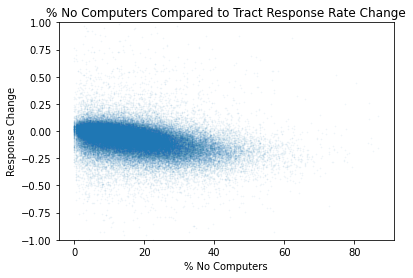

In [97]:
## comp vs tract change

# make a graph yay
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook

x = no_pr.no_int_pct
y = no_pr['10_20_tract_difference'] / 100

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% No Computers') 
# naming the y axis 
plt.ylabel('Response Change') 
# giving a title to my graph 
plt.title('% No Computers Compared to Tract Response Rate Change') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/no_comp_change_no_pr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


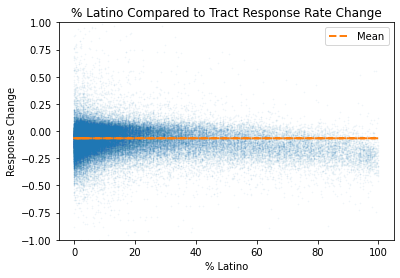

In [98]:
## latino vs tract change

# make a graph yay
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook

x = no_pr.latino_pct
y = no_pr['10_20_tract_difference'] / 100

#create mean line
y_mean = [np.mean(y)]*len(x)
fig,ax = plt.subplots()

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

# Plot the average line
mean_line = ax.plot(x,y_mean, label='Mean', linewidth=2, linestyle='--')

#change y axis limits
plt.ylim([-1,1])

# Make a legend
legend = ax.legend(loc='upper right')

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response Change') 
# giving a title to my graph 
plt.title('% Latino Compared to Tract Response Rate Change') 

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_change_no_pr.png',
#            bbox_inches='tight')

# function to show the plot 
plt.show() 


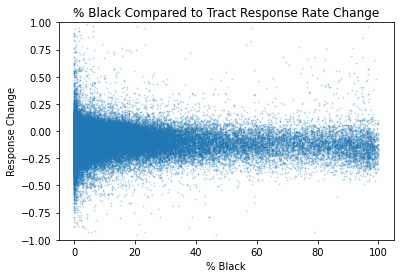

In [99]:
x = no_pr.black_pct
y = no_pr['10_20_tract_difference'] /100

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=1, alpha=0.2) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Black') 
# naming the y axis 
plt.ylabel('Response Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Black Compared to Tract Response Rate Change') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/black_change_nopr.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


### Race / Ethnicity

In [100]:
# show all tracts where Latino population 95% or higher by state
display(no_pr[no_pr.latino_pct >= 95].State.value_counts())

# show all 95 or higher Latino tracts in Texas
display(no_pr.loc[(no_pr.State == 'Texas') & (no_pr.latino_pct >= 95)])

Texas            221
California       192
Florida           98
Arizona           21
Illinois          15
Massachusetts      6
New Jersey         2
Name: State, dtype: int64

,Geo_Name,county,State,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct,Region,FIPS,party,candidatevotes,totalvotes
85318,"Tract 1505.01, Bexar",Bexar County,Texas,56.2,73.0,-23.013699,-1.9,58.1,71.0,-18.169014,4477,31.0,90.7,0.0,0.6,0.0,0.0,7.4,1.3,99.7,0.3,1379,90.1,9.9,70.9,29.1,3.1,67500.0,51.7,36862.0,36.473430,South,48029,democrat,319550,589645
85319,"Tract 1505.02, Bexar",Bexar County,Texas,56.4,74.0,-23.783784,-1.7,58.1,71.0,-18.169014,3425,36.5,90.4,0.1,0.0,0.0,0.0,7.9,1.6,97.8,2.2,1177,85.6,14.4,62.4,37.6,1.0,67800.0,39.6,36667.0,44.841270,South,48029,democrat,319550,589645
85320,"Tract 1507, Bexar",Bexar County,Texas,57.1,68.4,-16.520468,-1.0,58.1,71.0,-18.169014,7060,33.1,89.1,0.8,1.3,0.2,0.0,8.1,0.5,98.0,2.0,2122,93.3,6.7,62.3,37.7,0.0,73900.0,28.7,38594.0,34.040404,South,48029,democrat,319550,589645
85323,"Tract 1510, Bexar",Bexar County,Texas,58.3,71.6,-18.575419,0.2,58.1,71.0,-18.169014,3565,35.8,93.7,0.0,0.0,0.0,0.0,5.5,0.8,96.9,3.1,1141,89.8,10.2,60.8,39.2,8.2,82800.0,47.3,37113.0,36.292683,South,48029,democrat,319550,589645
85342,"Tract 1601, Bexar",Bexar County,Texas,51.6,71.5,-27.832168,-6.5,58.1,71.0,-18.169014,7188,28.6,90.7,0.0,2.9,0.0,0.0,6.4,0.0,98.7,1.3,2185,89.9,10.1,45.2,54.8,6.7,55700.0,59.2,24980.0,40.305344,South,48029,democrat,319550,589645
85343,"Tract 1602, Bexar",Bexar County,Texas,59.3,69.6,-14.798851,1.2,58.1,71.0,-18.169014,2995,35.6,79.2,0.2,0.0,0.0,0.0,20.4,0.1,96.2,3.8,985,91.9,8.1,76.2,23.8,5.0,79300.0,50.3,33281.0,31.712707,South,48029,democrat,319550,589645
85344,"Tract 1603, Bexar",Bexar County,Texas,61.8,75.6,-18.253968,3.7,58.1,71.0,-18.169014,5349,35.1,93.8,0.0,0.6,0.6,0.0,4.4,0.5,95.7,4.3,1854,94.9,5.1,69.8,30.2,2.4,74900.0,61.6,30324.0,33.125000,South,48029,democrat,319550,589645
85347,"Tract 1605.02, Bexar",Bexar County,Texas,61.1,75.4,-18.965517,3.0,58.1,71.0,-18.169014,4300,31.1,88.3,0.7,0.3,0.0,0.0,9.0,1.7,97.5,2.5,1293,90.7,9.3,66.1,33.9,3.1,73400.0,58.0,31758.0,39.641944,South,48029,democrat,319550,589645
85348,"Tract 1606, Bexar",Bexar County,Texas,56.8,70.9,-19.887165,-1.3,58.1,71.0,-18.169014,5288,30.4,95.8,0.0,0.0,0.4,0.0,3.4,0.3,99.0,1.0,1502,93.9,6.1,56.6,43.4,4.5,53600.0,40.5,32975.0,44.011339,South,48029,democrat,319550,589645
85349,"Tract 1607.01, Bexar",Bexar County,Texas,62.4,76.9,-18.855657,4.3,58.1,71.0,-18.169014,3802,38.1,92.2,0.2,2.5,0.0,0.0,5.2,0.0,98.8,1.2,1054,98.3,1.7,77.0,23.0,0.9,62100.0,58.4,38250.0,35.328185,South,48029,democrat,319550,589645


In [101]:
# compare high percentage Latino tracts to total # tracts in county

temp = pd.merge(pd.DataFrame(no_pr.loc[(no_pr.State == 'Texas') & (no_pr.latino_pct >= 95)].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'maj_Latino'}),
                 pd.DataFrame(no_pr.loc[(no_pr.State == 'Texas')].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'total'}),
                 how='left')

#calculate what % all tracts is 95% or more Latino in Texas
temp['maj_Latino_pct'] = (temp['maj_Latino']*100) / temp['total']

print(
    "Total majority latino tracts in Texas:", sum(temp['maj_Latino']),
    '\nMajority Latino as % of all Texas tracts:', (sum(temp['maj_Latino'])*100) / sum(temp['total']),
    "\n\n",temp)

Total majority latino tracts in Texas: 221 
Majority Latino as % of all Texas tracts: 7.694986072423398 

               county  maj_Latino  total  maj_Latino_pct
0     Cameron County          52    137       37.956204
1        Webb County          50     73       68.493151
2     El Paso County          35    186       18.817204
3       Bexar County          25    409        6.112469
4       Starr County          19     19      100.000000
5      Harris County          13   1252        1.038339
6    Maverick County           8     16       50.000000
7      Nueces County           4    112        3.571429
8     Kleberg County           4     18       22.222222
9   Val Verde County           3     18       16.666667
10    Tarrant County           3    610        0.491803
11     Zavala County           2      4       50.000000
12     Zapata County           1      4       25.000000
13      Duval County           1      3       33.333333
14  Jim Wells County           1     11        9.0909

In [102]:
display(
    "maj Latino",
    pd.DataFrame(no_pr.loc[(no_pr.State == 'Texas') & (no_pr.latino_pct >= 95)]).loc[(
        (pd.DataFrame(no_pr.loc[(no_pr.State == 'Texas') & (no_pr.latino_pct >= 95)])).groupby(
        'county')['county'].transform('size') > 10)].groupby(by='county').describe(),
    'all Texas',
    pd.DataFrame(no_pr.loc[(no_pr.State == 'Texas')]).groupby(by='county').describe())

'maj Latino'

2020_tract_rate             ... no_int_pct           
                         count       mean  ...        75%        max
county                                     ...                      
Bexar County              25.0  55.648000  ...  44.011339  54.322502
Cameron County            52.0  47.111538  ...  49.885972  70.935252
El Paso County            35.0  57.294286  ...  45.579046  79.383886
Harris County             13.0  48.507692  ...  37.967914  60.845070
Starr County              19.0  41.252632  ...  41.638716  56.227106
Webb County               50.0  40.962000  ...  60.472630  70.168067

[6 rows x 224 columns]

'all Texas'

2020_tract_rate             ... no_int_pct           
                               count       mean  ...        75%        max
county                                           ...                      
Anderson County                 10.0  50.830000  ...  35.911475  47.613504
Andrews County                   6.0  51.950000  ...  12.072470  22.630992
Angelina County                 21.0  54.180952  ...  18.697756  33.518390
Aransas County                  11.0  35.190909  ...  20.529794  25.625504
Archer County                    3.0  55.266667  ...  23.920656  25.593952
Armstrong County                 1.0  49.000000  ...  20.056497  20.056497
Atascosa County                 14.0  40.607143  ...  28.350054  34.326579
Austin County                    8.0  53.812500  ...  26.525330  43.388430
Bailey County                    2.0  48.100000  ...  26.764567  26.764567
Bandera County                   7.0  44.628571  ...  21.329640  21.887967
Bastrop County                  28.0  54.700000  ...  23.348694  30.786517
Baylor County                    2.0  41.850000  ...  22.523745  22.523745
Bee County                      11.0  42.245455  ...  38.892750  42.546584
Bell County                    112.0  57.069643  ...  23.671456  44.521912
Bexar County                   409.0  61.317359  ...  28.269699  57.544910
Blanco County                    4.0  46.775000  ...  16.658824  16.658824
Borden County                    1.0  37.600000  ...  18.390805  18.390805
Bosque County                    8.0  51.150000  ...  26.842301  27.859238
Bowie County                    29.0  56.793103  ...  31.568627  68.446026
Brazoria County                 83.0  61.081928  ...  15.844356  34.812287
Brazos County                   71.0  56.263380  ...  14.676830  34.698654
Brewster County                  3.0  32.900000  ...  25.655217  30.629371
Briscoe County                   1.0  39.800000  ...  21.044304  21.044304
Brooks County                    2.0  32.550000  ...  35.056905  37.619962
Brown County                    19.0  53.984211  ...  33.221699  66.875000
Burleson County                  8.0  44.825000  ...  29.701422  31.569966
Burnet County                   16.0  55.506250  ...  24.430024  27.078385
Caldwell County                 11.0  52.872727  ...  31.969764  35.339943
Calhoun County                   8.0  36.500000  ...  25.005631  34.168865
Callahan County                  3.0  54.133333  ...  33.455454  35.378440
Cameron County                 137.0  47.945255  ...  45.802651  70.935252
Camp County                      3.0  51.166667  ...  35.584993  41.515651
Carson County                    2.0  49.750000  ...  21.989864  23.023256
Cass County                     10.0  51.940000  ...  35.206575  48.767967
Castro County                    4.0  40.575000  ...  26.464549  28.473804
Chambers County                  6.0  47.633333  ...  30.413787  36.509146
Cherokee County                 14.0  48.257143  ...  29.119956  43.371758
Childress County                 3.0  51.033333  ...  25.309278  25.309278
Clay County                      5.0  56.440000  ...  24.915445  28.694901
Cochran County                   1.0  41.400000  ...  35.240964  35.240964
Coke County                      4.0  28.350000  ...  30.207065  30.207065
Coleman County                   4.0  40.050000  ...  24.504169  26.221805
Collin County                    6.0  65.983333  ...   7.393261  13.549302
Collingsworth County             1.0  44.300000  ...  25.781991  25.781991
Colorado County                  5.0  49.300000  ...  30.907278  34.513274
Comal County                    38.0  64.471053  ...  14.168080  20.793651
Comanche County                  7.0  50.271429  ...  40.739834  41.294196
Concho County                    1.0  28.000000  ...  27.949599  27.949599
Cooke County                    10.0  57.970000  ...  25.158615  30.841121
Coryell County                  17.0  61.170588  ...  18.346871  23.770492
Cottle County                    1.0  31.70000

In [103]:
display("0%", no_pr.loc[(no_pr.asian_pct == 0)].describe(),
"5%",no_pr.loc[(no_pr.asian_pct <= 5)].describe(),
"25%",no_pr.loc[(no_pr.asian_pct >= 25)].describe(),
"33%",no_pr.loc[(no_pr.asian_pct >= 33)].describe(),
"50%",no_pr.loc[(no_pr.asian_pct >= 50)].describe(),
"66%",no_pr.loc[(no_pr.asian_pct >= 66)].describe(),
"75%",no_pr.loc[(no_pr.asian_pct >= 75)].describe(),
"85%",no_pr.loc[(no_pr.asian_pct >= 85)].describe(),
df.describe())

'0%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.0,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,18424.000000,1.842400e+04,18424.000000,18424.000000,18424.000000
mean,57.064025,64.201715,-10.982013,-5.632517,62.696543,73.859314,-15.147951,3852.924229,40.703495,74.143981,19.890138,0.758055,0.0,0.053702,2.955254,2.196939,12.731692,87.268346,1772.624349,82.989693,17.010394,66.536262,33.463851,2.687853,1.329337e+05,39.681595,46731.853235,25.314700
std,13.284666,11.313344,20.189149,12.632647,4.593407,4.067533,3.232276,1910.931226,7.697345,30.330695,29.766686,3.124678,0.0,0.340199,7.100853,2.415918,22.465022,22.465000,817.864630,11.938133,11.938129,19.370972,19.370951,2.469040,8.986490e+04,16.313758,17778.337520,11.351282
min,2.800000,0.600000,-92.366412,-64.900000,53.200000,65.000000,-23.600000,75.000000,12.300000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,1.700000,0.000000,1.600000,0.600000,0.000000,1.150000e+04,0.000000,3894.000000,0.000000
25%,48.200000,58.000000,-18.688589,-13.300000,58.100000,71.000000,-17.894737,2462.000000,35.600000,61.700000,0.500000,0.000000,0.0,0.000000,0.000000,0.600000,1.100000,88.900000,1187.000000,78.400000,9.000000,54.600000,18.600000,1.100000,8.000000e+04,28.675000,34373.750000,17.295036
50%,57.600000,65.800000,-10.793920,-4.300000,62.400000,75.000000,-14.637681,3518.000000,40.600000,89.000000,3.500000,0.000000,0.0,0.000000,0.500000,1.500000,3.500000,96.500000,1629.000000,85.500000,14.500000,71.400000,28.600000,2.100000,1.107000e+05,39.400000,44328.500000,23.926868
75%,66.700000,72.200000,-3.758516,3.300000,67.400000,77.000000,-13.066667,4947.250000,45.300000,96.300000,27.000000,0.500000,0.0,0.000000,2.400000,3.000000,11.100000,98.900000,2267.000000,91.000000,21.600000,81.400000,45.400000,3.625000,1.571000e+05,50.500000,56360.000000,32.056384
max,91.100000,100.000000,1207.317073,30.700000,72.400000,82.000000,-7.777778,18602.000000,81.500000,100.000000,100.000000,96.800000,0.0,9.100000,84.000000,29.500000,100.000000,100.000000,11813.000000,100.000000,98.300000,99.400000,98.400000,40.300000,1.245800e+06,100.000000,205278.000000,86.920981


'5%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,72948.000000,7.294800e+04,72948.000000,72948.000000,72948.000000
mean,61.960932,67.132422,-7.342069,-1.170213,63.131145,74.006923,-14.731349,4758.438545,40.167548,77.333995,14.143027,0.811203,1.271348,0.092488,3.648112,2.699210,14.644352,85.355681,2067.462453,86.623916,13.376165,66.482612,33.517507,2.328097,1.965063e+05,38.770922,58240.863670,18.929652
std,13.648242,11.210332,74.133799,12.981329,4.494449,3.825873,3.324522,2660.559200,7.868939,24.352805,22.876542,3.022159,1.373406,0.533618,7.596538,2.507955,21.229551,21.229552,1077.623093,11.085077,11.085066,20.243308,20.243298,2.149474,1.484009e+05,15.382122,25297.223076,10.964592
min,2.500000,0.300000,-92.700000,-65.900000,49.700000,64.000000,-23.600000,75.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,1.700000,0.000000,1.100000,0.200000,0.000000,1.000000e+04,0.000000,3894.000000,0.000000
25%,52.900000,61.100000,-14.696970,-9.000000,58.900000,71.000000,-17.894737,3006.000000,34.900000,69.900000,0.700000,0.000000,0.000000,0.000000,0.100000,1.000000,2.100000,83.700000,1361.000000,82.800000,6.100000,54.200000,17.900000,0.900000,1.048000e+05,28.600000,41003.750000,10.658066
50%,63.200000,68.700000,-6.799433,0.200000,63.200000,74.000000,-14.594595,4298.000000,39.900000,87.100000,3.600000,0.100000,0.800000,0.000000,0.900000,2.100000,5.600000,94.400000,1889.000000,89.500000,10.500000,71.200000,28.800000,1.800000,1.570000e+05,38.500000,53515.000000,17.424773
75%,72.200000,74.900000,-0.580481,8.300000,67.400000,77.000000,-11.973684,5954.000000,44.900000,94.300000,15.800000,0.600000,2.100000,0.000000,3.400000,3.700000,16.300000,97.900000,2573.000000,93.900000,17.200000,82.100000,45.800000,3.100000,2.378250e+05,48.700000,70000.000000,25.242485
max,93.500000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,42926.000000,83.500000,100.000000,100.000000,96.800000,5.000000,54.600000,84.000000,48.800000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.900000,56.600000,1.995100e+06,100.000000,249063.000000,86.920981


'25%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3907.000000,3.907000e+03,3907.000000,3907.000000,3907.000000
mean,67.245406,70.694420,-4.926304,3.641976,63.603430,72.732531,-12.580719,5826.637830,38.607679,39.363629,5.986025,0.407960,40.826465,0.974456,6.692552,5.748503,17.195060,82.805017,2117.899155,93.441336,6.558741,55.734016,44.266035,1.810648,5.955942e+05,40.796570,92618.528027,9.690108
std,12.352172,9.441815,14.065235,11.721290,3.251294,2.717803,2.077638,3990.821201,6.074948,16.765981,7.308591,0.968543,13.804311,2.952331,8.159280,5.970019,13.703935,13.703971,1393.761871,5.695170,5.695233,24.117191,24.117152,1.769654,3.052918e+05,14.840123,39903.727894,7.796935
min,8.100000,11.700000,-79.245283,-54.200000,49.700000,64.000000,-22.343750,60.000000,19.600000,0.800000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,27.000000,24.000000,7.900000,0.000000,1.300000,0.800000,0.000000,1.590000e+04,0.000000,10802.000000,0.000000
25%,59.800000,65.200000,-11.374354,-3.500000,59.600000,71.000000,-13.066667,3771.000000,34.500000,25.500000,1.200000,0.000000,29.700000,0.000000,1.050000,2.400000,7.000000,76.300000,1331.000000,91.500000,3.000000,37.400000,25.050000,0.600000,3.838500e+05,30.300000,62544.000000,3.817508
50%,69.300000,71.900000,-3.400504,5.700000,64.500000,73.000000,-11.643836,5116.000000,38.400000,40.700000,3.400000,0.100000,36.700000,0.000000,3.500000,4.200000,13.000000,87.000000,1849.000000,94.600000,5.400000,58.800000,41.200000,1.300000,5.589000e+05,40.900000,88287.000000,7.988827
75%,76.350000,77.350000,2.086231,12.200000,64.500000,73.000000,-11.643836,6964.500000,42.700000,53.150000,8.000000,0.500000,48.900000,0.500000,9.300000,6.600000,23.700000,93.000000,2563.500000,97.000000,8.500000,74.950000,62.600000,2.500000,7.532000e+05,50.600000,115769.000000,13.387937
max,91.900000,100.000000,411.111111,29.100000,72.400000,82.000000,-9.473684,51536.000000,70.800000,72.200000,67.100000,39.400000,93.400000,44.100000,58.900000,43.800000,73.000000,100.000000,16056.000000,100.000000,92.100000,99.200000,98.700000,23.200000,1.960500e+06,100.000000,250000.000000,55.179704


'33%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2426.000000,2.426000e+03,2426.000000,2426.000000,2426.000000
mean,67.127411,70.881616,-5.497587,3.800206,63.327205,72.328112,-12.472528,5780.951772,39.155276,32.592663,4.902721,0.381698,48.331245,1.158739,6.585449,6.048269,16.027370,83.972754,2066.045342,93.687222,6.312861,55.336810,44.663273,1.771641,6.403632e+05,41.528566,93142.415087,9.935464
std,12.378821,9.326149,11.785076,11.780449,3.083751,2.609643,1.835125,3500.858517,5.926113,14.680923,6.193355,0.699858,12.450887,3.024199,7.652548,6.543605,12.133543,12.133597,1269.006538,5.516708,5.516801,23.809845,23.809781,1.666968,3.005069e+05,15.173103,40533.560671,8.004144
min,8.100000,19.300000,-76.335878,-54.200000,49.700000,64.000000,-22.343750,110.000000,19.800000,0.800000,0.000000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,36.300000,28.000000,7.900000,0.000000,1.300000,0.800000,0.000000,1.590000e+04,0.000000,10802.000000,0.000000
25%,59.800000,65.300000,-11.915081,-3.300000,59.600000,71.000000,-12.352941,3716.250000,35.200000,20.325000,0.900000,0.000000,38.200000,0.000000,1.000000,2.400000,6.900000,77.400000,1296.500000,91.700000,2.900000,37.550000,26.100000,0.600000,4.384250e+05,31.100000,61932.500000,3.884321
50%,69.150000,72.000000,-4.095662,5.800000,64.500000,73.000000,-11.643836,5114.000000,39.100000,32.400000,2.700000,0.100000,44.900000,0.000000,3.700000,4.200000,12.100000,87.900000,1801.000000,94.800000,5.200000,58.500000,41.500000,1.300000,6.109500e+05,41.800000,89263.000000,8.229786
75%,76.200000,77.600000,1.807229,12.375000,64.500000,73.000000,-11.643836,6992.250000,43.200000,44.600000,6.100000,0.500000,56.400000,0.700000,9.775000,6.600000,22.600000,93.100000,2491.750000,97.100000,8.300000,73.900000,62.450000,2.500000,7.913750e+05,51.600000,117306.000000,13.635436
max,90.700000,100.000000,92.219680,29.100000,72.400000,82.000000,-9.473684,32326.000000,67.200000,65.400000,44.200000,8.400000,93.400000,26.100000,46.400000,43.800000,63.700000,100.000000,10230.000000,100.000000,92.100000,99.200000,98.700000,11.700000,1.960500e+06,100.000000,247454.000000,54.073715


'50%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,9.150000e+02,915.000000,915.000000,915.000000
mean,67.749617,71.869945,-5.835480,4.869180,62.880437,71.739891,-12.374114,5444.742077,40.734536,21.527650,2.993989,0.361421,61.789399,1.337923,5.813443,6.175738,13.083169,86.916940,1899.786885,94.078689,5.921421,56.081202,43.918798,1.718142,7.020472e+05,42.294973,93566.209836,10.848245
std,11.678969,9.057520,11.061965,11.062265,2.758365,2.368672,1.463277,2847.317816,5.475780,9.881954,3.826599,0.612746,9.018550,2.905246,6.410353,6.783180,9.428236,9.428316,1081.606613,4.397338,4.397346,23.435431,23.435431,1.599665,2.883715e+05,15.950958,40518.254155,8.806824
min,22.300000,36.200000,-61.485320,-42.200000,58.100000,68.000000,-18.194444,110.000000,21.300000,0.800000,0.000000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,53.000000,69.000000,66.700000,0.000000,2.400000,0.800000,0.000000,3.870000e+04,0.000000,18650.000000,0.000000
25%,60.950000,67.100000,-12.491234,-1.700000,59.600000,69.000000,-12.352941,3685.500000,36.700000,14.300000,0.500000,0.000000,54.000000,0.000000,0.850000,2.100000,5.850000,81.550000,1253.000000,91.700000,2.800000,38.950000,24.600000,0.600000,5.220000e+05,30.900000,61170.000000,4.332147
50%,69.300000,72.800000,-4.986150,6.300000,64.500000,73.000000,-11.643836,5072.000000,40.800000,20.300000,1.700000,0.100000,60.300000,0.000000,3.300000,3.800000,10.300000,89.700000,1684.000000,95.100000,4.900000,58.200000,41.800000,1.300000,6.747000e+05,43.300000,91156.000000,8.809360
75%,76.400000,78.200000,1.293208,13.100000,64.500000,73.000000,-11.643836,6569.000000,44.150000,28.750000,4.000000,0.500000,67.300000,1.000000,9.400000,6.300000,18.450000,94.150000,2274.000000,97.200000,8.300000,75.400000,61.050000,2.350000,8.290000e+05,53.350000,117074.500000,14.912890
max,90.700000,90.800000,76.795580,29.100000,72.400000,81.000000,-9.473684,23482.000000,66.400000,46.300000,32.000000,4.500000,93.400000,21.100000,32.300000,31.200000,47.000000,100.000000,8683.000000,100.000000,33.300000,99.200000,97.600000,10.000000,1.936400e+06,100.000000,223634.000000,54.073715


'66%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,258.000000,2.580000e+02,258.000000,258.000000,258.000000
mean,67.567054,72.181395,-6.964707,4.656977,62.910078,71.798450,-12.405367,5014.852713,41.840310,14.444961,2.201550,0.318605,73.789147,0.923256,4.243798,4.084496,9.382558,90.617829,1681.302326,94.180233,5.819767,57.062403,42.937597,1.728682,7.715609e+05,41.439922,100861.251938,11.470276
std,13.831039,9.757709,11.606523,12.904916,2.610406,2.135051,1.425157,2052.728192,5.367694,6.013473,2.910172,0.495861,5.700676,2.104970,4.306251,3.996817,6.132262,6.132461,734.416093,4.388422,4.388422,26.037341,26.037341,1.855319,3.399987e+05,18.958745,50872.940379,10.670473
min,22.300000,43.800000,-61.485320,-42.200000,58.100000,68.000000,-18.169014,1107.000000,27.700000,1.000000,0.000000,0.000000,66.200000,0.000000,0.000000,0.000000,0.000000,70.800000,355.000000,72.900000,0.000000,2.400000,0.800000,0.000000,3.870000e+04,0.000000,18990.000000,0.000000
25%,58.525000,67.100000,-13.562662,-3.175000,59.600000,69.000000,-12.352941,3393.000000,38.200000,10.225000,0.300000,0.000000,69.050000,0.000000,0.825000,1.600000,4.500000,87.325000,1129.500000,91.700000,2.525000,36.750000,21.025000,0.500000,5.555000e+05,26.950000,53401.750000,3.134795
50%,69.750000,73.700000,-5.455970,7.700000,64.500000,73.000000,-11.643836,4895.000000,41.950000,14.400000,1.250000,0.100000,72.250000,0.000000,2.700000,3.100000,8.100000,91.900000,1636.500000,95.300000,4.700000,62.950000,37.050000,1.350000,7.120000e+05,42.300000,98906.000000,7.983707
75%,78.600000,79.550000,1.876346,14.625000,64.500000,73.000000,-11.643836,6456.500000,45.475000,18.900000,2.800000,0.500000,77.800000,0.700000,6.600000,4.800000,12.675000,95.500000,2121.750000,97.475000,8.300000,78.975000,63.250000,2.000000,8.790000e+05,55.425000,138664.750000,15.739348
max,90.700000,90.300000,14.609929,26.400000,68.900000,78.000000,-10.657895,11654.000000,57.300000,28.800000,15.400000,3.200000,93.400000,15.600000,18.900000,20.700000,29.200000,100.000000,4853.000000,100.000000,27.100000,99.200000,97.600000,9.000000,1.936400e+06,100.000000,223634.000000,54.073715


'75%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,9.700000e+01,97.000000,97.000000,97.000000
mean,63.112371,70.038144,-10.767485,0.440206,62.672165,71.587629,-12.486976,4777.195876,42.567010,10.948454,1.408247,0.352577,80.005155,0.785567,3.265979,3.242268,7.194845,92.805155,1575.618557,93.702062,6.297938,50.386598,49.613402,1.985567,7.915134e+05,40.763918,91858.948454,16.148316
std,15.910461,11.097949,13.669328,14.794556,2.848748,2.366223,1.309598,2078.219569,5.445119,5.050518,2.186687,0.447933,3.728700,1.740031,3.561773,3.646340,4.872187,4.872187,675.014575,4.928678,4.928678,28.329908,28.329908,2.161066,3.684409e+05,20.163024,59065.496996,13.138811
min,22.300000,45.900000,-61.485320,-42.200000,58.900000,68.000000,-14.637681,1107.000000,27.700000,1.000000,0.000000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,81.000000,356.000000,72.900000,0.000000,2.400000,6.400000,0.000000,3.870000e+04,0.000000,18990.000000,0.522648
25%,51.800000,63.600000,-18.342391,-9.900000,58.900000,69.000000,-14.637681,3315.000000,38.500000,8.200000,0.200000,0.000000,77.300000,0.000000,0.400000,1.100000,3.000000,89.400000,1074.000000,90.100000,2.200000,24.700000,26.200000,0.400000,5.515000e+05,21.300000,42202.000000,4.697987
50%,64.800000,71.900000,-11.038961,2.100000,64.500000,73.000000,-11.643836,4588.000000,42.200000,10.800000,0.600000,0.000000,78.800000,0.000000,2.000000,2.600000,6.500000,93.500000,1500.000000,94.200000,5.800000,44.600000,55.400000,1.500000,7.839000e+05,45.300000,67150.000000,13.582090
75%,77.800000,78.100000,0.417246,13.300000,64.500000,73.000000,-11.643836,6085.000000,47.000000,14.900000,1.900000,0.700000,82.000000,0.700000,4.700000,3.700000,10.600000,97.000000,2017.000000,97.800000,9.900000,73.800000,75.300000,2.400000,8.993000e+05,57.100000,150250.000000,25.808745
max,89.600000,89.600000,12.011173,25.100000,68.900000,78.000000,-10.657895,9164.000000,57.300000,21.400000,15.400000,2.100000,93.400000,8.400000,13.400000,16.700000,19.000000,100.000000,3911.000000,100.000000,27.100000,93.600000,97.600000,9.000000,1.866200e+06,80.700000,208125.000000,54.073715


'85%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000
mean,56.228571,69.500000,-18.653038,-6.457143,62.685714,71.571429,-12.459672,4196.142857,48.457143,6.242857,1.557143,0.514286,88.528571,0.385714,0.957143,1.800000,2.514286,97.485714,1906.285714,91.014286,8.985714,24.071429,75.928571,4.471429,583957.142857,52.042857,30269.00000,34.929283
std,6.781031,5.160103,12.126016,7.770641,3.541388,2.935821,1.567482,1699.995140,2.496569,2.228495,1.885786,0.511301,3.736627,0.362531,0.877225,1.676305,2.668600,2.668600,731.813208,5.736848,5.736848,15.266381,15.266381,3.287712,229253.090544,11.244681,10351.84721,15.479808
min,49.600000,64.300000,-33.556150,-14.800000,58.900000,68.000000,-14.637681,2282.000000,44.700000,3.700000,0.000000,0.000000,85.000000,0.000000,0.000000,0.200000,0.000000,92.600000,957.000000,81.700000,1.200000,4.500000,55.500000,1.200000,284200.000000,37.800000,18990.00000,17.260579
25%,51.650000,65.650000,-26.040550,-11.600000,59.250000,69.000000,-13.495311,2766.000000,47.000000,4.500000,0.250000,0.000000,85.100000,0.000000,0.350000,0.550000,0.750000,96.450000,1305.500000,88.450000,5.200000,14.100000,66.500000,2.050000,431950.000000,43.700000,20855.50000,23.762371
50%,54.000000,66.500000,-19.398496,-9.000000,64.500000,73.000000,-11.643836,4692.000000,47.900000,5.700000,0.300000,0.600000,88.600000,0.600000,0.700000,1.700000,1.600000,98.400000,2288.000000,90.100000,9.900000,24.300000,75.700000,2.200000,497100.000000,53.400000,30676.00000,27.377108
75%,60.150000,73.700000,-14.400732,-2.500000,64.500000,73.000000,-11.643836,4897.500000,50.400000,8.050000,2.750000,0.950000,91.250000,0.700000,1.550000,2.300000,3.550000,99.250000,2289.000000,94.800000,11.550000,33.500000,85.900000,7.700000,794600.000000,57.950000,38422.50000,49.134418
max,66.400000,77.000000,3.265941,6.800000,67.900000,76.000000,-10.657895,7072.000000,51.800000,9.200000,4.600000,1.100000,93.400000,0.700000,2.200000,5.000000,7.400000,100.000000,2910.000000,98.800000,18.300000,44.500000,95.500000,8.400000,853300.000000,69.800000,43661.00000,54.073715


,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,103540.000000,102847.000000,1.028380e+05,103540.000000,103540.000000,103540.000000,103540.000000,103540.000000,103321.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103336.000000,103540.000000,103294.000000,103294.000000,103270.000000,103270.000000,102398.000000,1.015520e+05,103123.000000,102963.000000,103270.000000
mean,62.482062,67.690365,inf,-0.317306,62.799368,73.618041,-14.835571,4949.205833,39.463309,73.245816,13.083205,0.889803,4.900626,0.170504,4.527902,3.181698,17.133094,82.866948,2087.127487,87.810794,12.189295,63.984057,36.016050,2.266941,2.521893e+05,39.182103,64252.382565,17.074833
std,14.496564,11.313510,NaN,13.324352,5.775788,4.247514,4.888865,2963.114947,7.819423,24.336115,20.767391,4.403487,9.112682,1.097695,8.458077,3.116841,22.717655,22.717659,1146.099229,10.974492,10.974486,22.449101,22.449104,2.280203,2.144128e+05,15.467814,31698.656049,11.583500
min,0.000000,0.000000,-1.000000e+02,-68.900000,28.100000,54.000000,-47.962963,0.000000,5.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+04,0.000000,3025.000000,0.000000
25%,53.400000,61.700000,-1.428140e+01,-8.200000,58.900000,71.000000,-17.894737,3119.000000,34.200000,61.700000,1.000000,0.000000,0.300000,0.000000,0.200000,1.200000,2.800000,79.100000,1360.000000,84.400000,5.100000,50.200000,18.500000,0.800000,1.172000e+05,29.000000,42359.500000,8.201893
50%,64.200000,69.200000,-6.050955e+00,1.200000,64.500000,74.000000,-14.025974,4450.000000,39.100000,81.300000,4.200000,0.100000,1.600000,0.000000,1.300000,2.400000,7.600000,92.400000,1898.000000,90.800000,9.200000,69.100000,30.900000,1.800000,1.817000e+05,38.900000,57348.000000,15.015480
75%,73.400000,75.500000,1.436782e-01,9.400000,67.200000,76.000000,-11.666667,6132.000000,44.200000,92.100000,14.700000,0.600000,5.200000,0.000000,4.700000,4.300000,20.900000,97.200000,2594.000000,94.900000,15.600000,81.500000,49.800000,3.100000,3.110000e+05,49.100000,78846.000000,23.436323
max,98.100000,100.000000,inf,39.200000,72.400000,82.000000,-7.777778,70271.000000,84.500000,100.000000,100.000000,100.000000,93.400000,76.200000,100.000000,66.700000,100.000000,100.000000,26436.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.995100e+06,100.000000,250000.000000,100.000000


In [104]:
display(no_pr.describe(),
        "0%", no_pr.loc[(no_pr.black_pct == 0)].describe(),
"5%",no_pr.loc[(no_pr.black_pct <= 5)].describe(),
"25%",no_pr.loc[(no_pr.black_pct >= 25)].describe(),
"33%",no_pr.loc[(no_pr.black_pct >= 33)].describe(),
"50%",no_pr.loc[(no_pr.black_pct >= 50)].describe(),
"66%",no_pr.loc[(no_pr.black_pct >= 66)].describe(),
"75%",no_pr.loc[(no_pr.black_pct >= 75)].describe(),
"90%",no_pr.loc[(no_pr.black_pct >= 90)].describe(),
"95%",no_pr.loc[(no_pr.black_pct >= 95)].describe())

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,98303.000000,9.830300e+04,98303.000000,98303.000000,98303.000000
mean,63.400729,68.053598,-6.605497,0.111141,63.289588,73.899616,-14.390065,4986.417007,39.582015,73.656198,13.074033,0.731885,4.914309,0.169601,4.312943,3.140615,15.874350,84.125688,2102.056448,88.180560,11.819524,64.616929,35.383177,2.213453,2.535411e+05,39.021877,64901.445175,16.718502
std,13.560829,10.933295,64.373845,12.887637,4.336303,3.659632,3.270482,2945.217100,7.655609,24.178611,20.822669,2.681971,9.114049,1.065492,8.014252,2.998347,20.597208,20.597211,1131.132795,10.403032,10.403024,21.579040,21.579032,2.083474,2.136017e+05,15.290469,31013.762234,10.919552
min,0.000000,0.300000,-100.000000,-65.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,0.900000,0.200000,0.000000,1.000000e+04,0.000000,3894.000000,0.000000
25%,54.500000,62.200000,-13.716555,-7.700000,58.900000,71.000000,-16.811594,3161.000000,34.400000,62.300000,1.000000,0.000000,0.300000,0.000000,0.200000,1.200000,2.700000,80.300000,1376.000000,84.800000,5.100000,50.900000,18.300000,0.800000,1.184000e+05,28.900000,43220.500000,8.245397
50%,64.800000,69.500000,-5.776173,1.500000,64.500000,74.000000,-14.025974,4481.000000,39.200000,81.800000,4.100000,0.100000,1.600000,0.000000,1.200000,2.400000,7.300000,92.700000,1909.000000,91.000000,9.000000,69.400000,30.600000,1.700000,1.836000e+05,38.800000,58010.000000,14.880000
75%,73.700000,75.700000,0.265604,9.600000,67.400000,76.000000,-11.643836,6160.000000,44.200000,92.300000,14.600000,0.600000,5.300000,0.000000,4.500000,4.300000,19.700000,97.300000,2602.000000,94.900000,15.200000,81.700000,49.100000,3.000000,3.140000e+05,48.800000,79328.500000,22.991396
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,100.000000,96.800000,93.400000,60.900000,84.000000,49.900000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,99.100000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'0%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.0,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8196.000000,8.196000e+03,8196.000000,8196.000000,8196.000000
mean,62.306918,67.231259,-7.433979,-1.626635,63.933553,74.097731,-13.767078,4082.016837,44.050927,91.298316,0.0,1.004649,2.829087,0.138067,2.575817,2.150476,12.012372,87.987640,1887.926061,83.884370,16.115739,77.328648,22.671474,2.112701,2.587260e+05,35.254868,66658.534895,17.612859
std,15.866016,13.375927,17.262139,14.741846,4.619518,4.042705,2.964055,2282.364396,8.304949,13.776428,0.0,4.541228,8.734689,1.174981,6.902896,2.736126,21.971626,21.971617,964.148390,15.434283,15.434270,14.068010,14.067984,2.320255,2.375046e+05,17.022517,30281.766049,10.582477
min,2.800000,0.600000,-87.960340,-64.600000,53.200000,65.000000,-23.600000,60.000000,13.300000,0.800000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,6.700000,0.400000,0.000000,1.720000e+04,0.000000,9750.000000,0.000000
25%,52.700000,61.000000,-14.315739,-9.900000,59.800000,71.000000,-15.405405,2533.000000,39.300000,91.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.600000,1.300000,89.700000,1219.000000,79.400000,5.800000,71.500000,13.100000,0.700000,1.175000e+05,23.700000,47061.000000,9.752100
50%,64.900000,70.200000,-5.957114,0.600000,65.200000,75.000000,-13.815789,3633.000000,44.000000,95.800000,0.0,0.100000,0.500000,0.000000,0.300000,1.400000,3.500000,96.500000,1698.000000,88.900000,11.100000,80.500000,19.500000,1.600000,1.754000e+05,34.400000,59683.000000,16.284331
75%,74.300000,76.500000,0.165429,9.100000,67.400000,77.000000,-11.643836,5151.250000,48.300000,98.000000,0.0,0.700000,1.800000,0.000000,1.800000,2.900000,10.300000,98.700000,2381.000000,94.200000,20.600000,86.900000,28.500000,2.800000,3.011000e+05,46.000000,76888.000000,23.590674
max,92.500000,100.000000,504.000000,35.000000,72.400000,82.000000,-7.777778,24086.000000,81.500000,100.000000,0.0,96.800000,85.000000,54.600000,75.800000,43.800000,100.000000,100.000000,11813.000000,100.000000,98.300000,99.600000,93.300000,56.600000,1.988800e+06,100.000000,244512.000000,86.920981


'5%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,53146.000000,5.314600e+04,53146.000000,53146.000000,53146.000000
mean,65.850905,69.926433,-5.485175,1.887834,63.963072,74.110676,-13.732045,4841.177887,41.747328,85.967755,1.538887,0.889837,4.907348,0.195273,3.624640,2.875744,14.777257,85.222794,2087.726414,88.180680,11.819418,71.429137,28.570972,1.995360,2.899929e+05,36.709442,71575.928725,15.082761
std,13.821899,11.195973,83.277489,13.001086,4.331876,3.753334,2.943355,2545.954332,7.796192,15.640312,1.434849,3.396904,10.077486,1.324157,7.698333,3.101179,21.741741,21.741737,1068.273664,11.666904,11.666890,18.410484,18.410470,1.875361,2.425568e+05,15.632551,32465.885261,9.576959
min,2.800000,0.300000,-92.700000,-65.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,1.200000,0.400000,0.000000,1.280000e+04,0.000000,7169.000000,0.000000
25%,58.000000,64.900000,-11.897910,-5.200000,59.800000,72.000000,-15.000000,3168.000000,36.800000,82.900000,0.300000,0.000000,0.200000,0.000000,0.100000,1.000000,2.200000,84.100000,1398.000000,85.400000,4.600000,62.100000,15.100000,0.800000,1.335000e+05,26.400000,49196.000000,7.589471
50%,68.000000,71.800000,-4.381198,3.700000,64.500000,74.000000,-13.589744,4423.000000,41.600000,91.400000,1.100000,0.100000,1.300000,0.000000,0.800000,2.100000,5.800000,94.200000,1910.000000,91.700000,8.300000,76.000000,24.000000,1.600000,2.089000e+05,36.100000,63281.000000,13.752030
75%,76.100000,77.500000,0.904831,11.300000,67.400000,77.000000,-11.643836,6027.000000,46.100000,95.600000,2.500000,0.700000,4.600000,0.000000,3.200000,3.800000,15.900000,97.800000,2576.000000,95.400000,14.600000,84.900000,37.900000,2.700000,3.599000e+05,46.300000,86250.000000,20.910709
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,42926.000000,83.500000,100.000000,5.000000,96.800000,93.400000,60.900000,78.800000,49.900000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.600000,98.800000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'25%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,15923.000000,1.592300e+04,15923.000000,15923.000000,15923.000000
mean,54.880556,61.675250,-10.591777,-7.107819,61.988375,73.476418,-15.643329,4549.781699,36.099893,36.076945,53.600716,0.402223,2.684639,0.078704,4.219079,2.937782,12.585386,87.414633,1921.458645,85.260453,14.739616,50.429756,49.570351,2.845707,1.612178e+05,45.950744,44405.436099,24.856433
std,11.395132,9.925674,32.221191,11.852502,4.190308,3.683615,3.476548,3131.729848,6.256846,21.086988,22.950518,1.139178,4.707422,0.423450,7.013517,2.666003,14.867440,14.867454,1124.262594,9.306562,9.306555,21.426789,21.426785,2.619705,1.370760e+05,13.764853,20727.267499,13.002274
min,0.000000,2.400000,-100.000000,-64.900000,54.700000,65.000000,-23.600000,372.000000,12.500000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.900000,28.000000,19.400000,0.000000,0.900000,0.800000,0.000000,1.260000e+04,0.000000,3894.000000,0.000000
25%,47.100000,55.400000,-18.247522,-14.800000,58.900000,71.000000,-18.194444,2614.000000,31.800000,17.400000,33.100000,0.000000,0.000000,0.000000,0.200000,1.000000,2.200000,82.900000,1197.000000,80.400000,7.800000,34.500000,32.950000,1.100000,7.850000e+04,36.900000,30141.000000,14.836899
50%,54.800000,62.500000,-11.237553,-6.700000,60.100000,74.000000,-15.000000,3991.000000,35.500000,38.100000,47.400000,0.000000,0.900000,0.000000,1.500000,2.300000,6.700000,93.300000,1726.000000,87.000000,13.000000,50.900000,49.100000,2.200000,1.198000e+05,46.000000,39821.000000,23.678862
75%,62.700000,68.800000,-4.130301,1.100000,67.200000,76.000000,-12.162162,5699.000000,39.950000,54.200000,72.800000,0.400000,3.200000,0.000000,4.900000,4.200000,17.100000,97.800000,2424.000000,92.200000,19.600000,67.050000,65.500000,3.900000,1.853500e+05,55.000000,53844.000000,33.611511
max,88.400000,91.100000,2787.500000,26.400000,72.400000,82.000000,-7.777778,51536.000000,67.500000,74.400000,100.000000,33.500000,53.000000,9.800000,65.700000,29.000000,78.100000,100.000000,16056.000000,100.000000,80.600000,99.200000,99.100000,33.000000,1.653400e+06,100.000000,184750.000000,77.842566


'33%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,12019.000000,1.201900e+04,12019.000000,12019.000000,12019.000000
mean,53.649963,60.662251,-11.342821,-8.393194,62.043157,73.481238,-15.575500,4250.016807,36.010691,29.247450,61.720884,0.358682,2.182902,0.068167,3.713936,2.707788,10.824661,89.175364,1820.204260,84.376695,15.623363,49.015392,50.984724,2.908578,1.518505e+05,47.308803,41668.117730,26.559782
std,11.137127,9.881337,16.880563,11.752918,4.214608,3.744331,3.411160,2545.231885,6.290927,18.656826,20.667315,1.025770,3.924941,0.409723,6.204066,2.536505,13.208859,13.208876,965.489579,9.623896,9.623887,21.052546,21.052539,2.656154,1.351582e+05,13.650272,19602.187639,13.067901
min,0.000000,4.100000,-100.000000,-64.900000,54.700000,65.000000,-23.600000,372.000000,12.500000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.600000,28.000000,19.400000,0.000000,0.900000,0.800000,0.000000,1.260000e+04,0.000000,3894.000000,0.000000
25%,46.200000,54.400000,-18.706917,-16.000000,58.900000,71.000000,-18.194444,2468.500000,31.600000,11.600000,42.800000,0.000000,0.000000,0.000000,0.000000,0.800000,1.700000,85.400000,1145.000000,79.200000,8.400000,33.550000,35.100000,1.100000,7.360000e+04,38.600000,28235.000000,16.672158
50%,53.400000,61.400000,-11.821705,-7.900000,60.100000,74.000000,-14.683544,3757.000000,35.400000,29.800000,58.400000,0.000000,0.600000,0.000000,1.300000,2.100000,5.600000,94.400000,1641.000000,86.100000,13.900000,49.300000,50.700000,2.300000,1.112000e+05,47.400000,37194.000000,25.596944
75%,61.300000,67.700000,-4.834629,-0.200000,67.200000,76.000000,-12.162162,5435.000000,39.900000,45.500000,80.400000,0.300000,2.600000,0.000000,4.500000,3.900000,14.600000,98.300000,2327.500000,91.600000,20.800000,64.900000,66.450000,4.000000,1.699000e+05,56.400000,50328.000000,35.446090
max,88.400000,88.500000,1207.317073,25.700000,72.400000,82.000000,-7.777778,28272.000000,67.500000,66.400000,100.000000,33.500000,49.400000,9.800000,54.600000,22.900000,74.400000,100.000000,13028.000000,100.000000,80.600000,99.200000,99.100000,33.000000,1.556500e+06,100.000000,184750.000000,77.842566


'50%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7442.000000,7.442000e+03,7442.000000,7442.000000,7442.000000
mean,52.221231,59.322104,-11.613998,-10.065614,62.286845,73.510884,-15.282930,3901.743214,36.095364,18.449503,74.761610,0.275934,1.439882,0.052298,2.701841,2.318530,7.525652,92.474389,1699.952029,82.975060,17.025034,47.475625,52.524483,2.956907,1.436433e+05,49.639250,38687.324510,29.039177
std,11.031233,9.953186,19.394772,11.847972,4.271177,3.825266,3.290575,2475.736784,6.426059,13.355404,15.118314,0.734646,2.744847,0.363424,4.511175,2.351451,9.302165,9.302189,950.799609,10.137451,10.137424,20.397941,20.397953,2.751782,1.389477e+05,13.543139,19284.784471,13.302382
min,4.000000,4.100000,-92.366412,-64.900000,54.700000,65.000000,-23.600000,375.000000,12.500000,0.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.200000,161.000000,32.400000,0.000000,0.900000,0.800000,0.000000,1.330000e+04,0.000000,3894.000000,0.000000
25%,44.700000,52.900000,-19.314501,-17.800000,58.900000,71.000000,-18.169014,2247.000000,31.600000,6.300000,60.900000,0.000000,0.000000,0.000000,0.000000,0.600000,1.000000,89.500000,1066.250000,77.200000,9.500000,32.425000,37.900000,1.100000,6.700000e+04,40.800000,25641.250000,19.087773
50%,51.800000,59.700000,-12.476440,-9.700000,60.100000,74.000000,-14.637681,3392.000000,35.600000,16.500000,74.800000,0.000000,0.300000,0.000000,0.800000,1.700000,3.900000,96.100000,1523.000000,84.500000,15.500000,47.600000,52.400000,2.300000,9.740000e+04,49.900000,33789.500000,28.562364
75%,59.700000,66.400000,-5.574471,-1.900000,67.200000,76.000000,-12.000000,4953.000000,40.100000,29.700000,88.800000,0.200000,1.600000,0.000000,3.200000,3.400000,10.500000,99.000000,2136.750000,90.500000,22.800000,62.100000,67.575000,4.100000,1.594000e+05,58.600000,46190.500000,38.104976
max,87.700000,86.500000,1207.317073,23.000000,72.400000,82.000000,-10.519481,28272.000000,67.500000,49.600000,100.000000,9.400000,27.600000,9.800000,40.600000,22.900000,61.800000,100.000000,13028.000000,100.000000,67.600000,99.200000,99.100000,33.000000,1.542200e+06,100.000000,174469.000000,77.842566


'66%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4823.000000,4.823000e+03,4823.000000,4823.000000,4823.000000
mean,51.203939,58.351400,-11.773494,-11.397636,62.601576,73.594236,-14.958859,3592.430023,36.226581,10.905370,84.057848,0.218122,0.947149,0.040182,1.923886,1.907713,5.211756,94.788285,1590.122953,81.804375,18.195708,46.358366,53.641758,2.993158,1.362890e+05,51.380987,36712.465063,30.782501
std,11.097476,10.051421,22.326258,12.111571,4.303129,3.860995,3.107830,2216.278877,6.547214,8.447273,9.792135,0.628702,1.933986,0.280543,3.278382,2.053596,6.552075,6.552092,838.911501,10.800501,10.800506,19.877029,19.877040,2.839498,1.311954e+05,13.436490,19225.669405,13.501074
min,4.000000,4.100000,-92.366412,-64.900000,57.200000,65.000000,-23.600000,375.000000,12.500000,0.000000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,161.000000,32.400000,0.000000,1.200000,0.800000,0.000000,1.330000e+04,0.000000,3894.000000,0.000000
25%,43.600000,51.900000,-20.143765,-19.300000,58.900000,72.000000,-17.894737,2074.500000,31.700000,3.600000,75.600000,0.000000,0.000000,0.000000,0.000000,0.400000,0.700000,92.800000,1014.000000,75.600000,10.000000,32.200000,40.100000,1.000000,6.300000e+04,42.900000,24155.000000,20.711474
50%,50.600000,58.600000,-12.816456,-11.200000,60.700000,74.000000,-14.637681,3119.000000,35.800000,9.000000,85.000000,0.000000,0.100000,0.000000,0.500000,1.300000,2.700000,97.300000,1422.000000,83.600000,16.400000,46.100000,53.900000,2.300000,8.940000e+04,52.100000,31342.000000,30.425300
75%,58.700000,65.600000,-5.791664,-3.100000,67.400000,76.000000,-12.000000,4564.500000,40.400000,17.200000,92.600000,0.100000,1.000000,0.000000,2.400000,2.800000,7.200000,99.300000,1988.000000,90.000000,24.400000,59.900000,67.800000,4.200000,1.532500e+05,60.200000,43044.500000,39.831872
max,86.700000,85.100000,1207.317073,20.600000,72.400000,82.000000,-10.519481,18602.000000,64.300000,33.300000,100.000000,9.100000,27.600000,8.200000,29.100000,20.400000,50.000000,100.000000,7123.000000,100.000000,67.600000,99.200000,98.800000,32.200000,1.542200e+06,100.000000,174469.000000,77.842566


'75%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3695.000000,3.695000e+03,3695.000000,3695.000000,3695.000000
mean,50.621651,57.841137,-11.909293,-12.222625,62.844276,73.680379,-14.733376,3425.613802,36.346225,7.654452,88.200595,0.194073,0.729932,0.035210,1.512341,1.674100,4.019838,95.980217,1540.035453,81.001624,18.998430,45.864871,54.135291,3.041786,1.323097e+05,52.082923,35726.561299,31.740025
std,11.045813,10.033098,24.501509,12.137240,4.332347,3.890263,3.004022,2141.296278,6.700557,5.909706,7.042728,0.581319,1.485681,0.244246,2.606942,1.830537,5.045104,5.045121,821.986811,11.142020,11.142034,19.426590,19.426601,2.921468,1.253575e+05,13.381829,19199.481241,13.596195
min,4.000000,4.100000,-92.366412,-64.900000,57.200000,65.000000,-23.600000,375.000000,12.500000,0.000000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,64.200000,161.000000,32.400000,0.000000,1.200000,0.800000,0.000000,1.330000e+04,0.000000,3894.000000,0.000000
25%,43.000000,51.100000,-20.505705,-20.400000,58.900000,72.000000,-17.361111,1968.000000,31.600000,2.600000,82.200000,0.000000,0.000000,0.000000,0.000000,0.300000,0.500000,94.300000,980.500000,74.400000,10.400000,32.050000,41.300000,1.000000,6.065000e+04,43.800000,23538.000000,21.858031
50%,49.900000,58.000000,-13.293651,-12.000000,60.700000,74.000000,-14.637681,2949.000000,35.900000,6.500000,89.000000,0.000000,0.000000,0.000000,0.300000,1.100000,2.000000,98.000000,1381.000000,82.800000,17.200000,45.500000,54.500000,2.300000,8.650000e+04,52.800000,30346.000000,31.568816
75%,58.000000,65.100000,-6.117246,-3.900000,67.400000,76.000000,-12.000000,4347.000000,40.600000,11.600000,94.400000,0.000000,0.900000,0.000000,1.800000,2.500000,5.700000,99.500000,1921.500000,89.600000,25.600000,58.700000,67.950000,4.200000,1.508500e+05,60.800000,41540.500000,40.762591
max,86.700000,85.100000,1207.317073,19.800000,69.700000,82.000000,-10.519481,18602.000000,62.700000,24.700000,100.000000,9.100000,13.800000,6.800000,21.000000,15.400000,35.800000,100.000000,7123.000000,100.000000,67.600000,99.200000,98.800000,32.200000,1.335500e+06,100.000000,174469.000000,77.842566


'90%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000,1694.000000
mean,49.572432,57.175738,-12.365069,-13.797816,63.370248,73.877214,-14.257259,3173.021842,36.761039,3.117946,94.702007,0.149174,0.313518,0.020956,0.593388,1.102361,1.645514,98.354486,1479.193625,78.713223,21.286777,45.749351,54.250649,3.133825,108592.502952,53.814227,32553.224321,34.260430
std,11.071201,9.906816,33.259351,12.612617,4.398546,3.949209,2.805831,2080.561680,7.072096,2.336375,2.773520,0.452331,0.706781,0.121241,1.136093,1.258636,2.097877,2.097877,808.752193,11.548782,11.548782,18.299614,18.299614,2.915872,96016.006845,13.508556,16302.741817,13.497890
min,21.300000,4.100000,-48.861284,-46.100000,57.200000,65.000000,-23.600000,375.000000,12.500000,0.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,84.400000,179.000000,33.300000,0.000000,2.400000,1.100000,0.000000,13300.000000,0.000000,3998.000000,0.748752
25%,41.800000,50.300000,-22.273917,-22.900000,58.900000,72.000000,-16.086957,1801.250000,31.600000,1.200000,92.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,97.600000,944.250000,71.900000,12.400000,32.700000,42.425000,1.100000,52200.000000,45.625000,22304.000000,24.547132
50%,48.950000,57.150000,-14.374127,-13.800000,63.200000,76.000000,-14.025974,2638.000000,36.500000,2.600000,94.800000,0.000000,0.000000,0.000000,0.000000,0.700000,0.900000,99.100000,1332.000000,80.300000,19.700000,46.000000,54.000000,2.400000,75600.000000,54.150000,28048.500000,34.150636
75%,57.175000,64.700000,-6.763631,-4.825000,67.900000,77.000000,-11.666667,3968.750000,41.500000,4.700000,96.900000,0.000000,0.300000,0.000000,0.700000,1.700000,2.400000,100.000000,1796.500000,87.600000,28.100000,57.575000,67.300000,4.300000,125450.000000,62.600000,37500.000000,42.609783
max,82.400000,85.100000,1207.317073,17.700000,69.700000,82.000000,-10.657895,17562.000000,62.300000,9.800000,100.000000,4.700000,6.000000,1.500000,8.900000,9.400000,15.600000,100.000000,7123.000000,100.000000,66.700000,98.900000,97.600000,25.600000,690900.000000,100.000000,133015.000000,77.842566


'95%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000,819.000000
mean,49.119048,57.076801,-12.427581,-14.546764,63.665812,74.021978,-14.025133,2889.969475,37.272405,1.598291,97.170696,0.101465,0.173504,0.021368,0.288156,0.645788,0.909768,99.090232,1402.213675,76.864835,23.135165,46.900855,53.099145,3.154945,98284.737485,55.302808,30764.669109,36.150294
std,11.289183,9.968004,45.243918,12.758114,4.394145,3.961552,2.768136,1723.486636,7.288761,1.230221,1.345733,0.310174,0.453181,0.119984,0.617368,0.778448,1.305668,1.305668,714.760014,12.028783,12.028783,17.448256,17.448256,3.053410,86836.117879,13.231083,14889.036363,13.118103
min,22.800000,4.100000,-48.861284,-45.400000,57.200000,65.000000,-23.600000,464.000000,12.500000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.300000,243.000000,33.300000,0.000000,2.400000,1.100000,0.000000,13700.000000,0.000000,3998.000000,2.550572
25%,41.100000,49.850000,-23.124743,-24.800000,58.900000,72.000000,-16.086957,1682.500000,32.000000,0.600000,96.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.700000,908.000000,69.450000,13.600000,35.000000,41.700000,1.100000,49050.000000,48.000000,22091.000000,27.822349
50%,48.400000,57.200000,-15.307820,-14.000000,63.200000,76.000000,-13.589744,2533.000000,37.000000,1.400000,97.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.400000,99.600000,1295.000000,78.400000,21.600000,48.000000,52.000000,2.400000,66400.000000,55.600000,27247.000000,35.542169
75%,57.200000,64.600000,-6.921676,-5.000000,67.900000,77.000000,-11.666667,3563.000000,42.100000,2.400000,98.200000,0.000000,0.000000,0.000000,0.300000,1.100000,1.300000,100.000000,1726.000000,86.400000,30.550000,58.300000,65.000000,4.350000,116250.000000,64.300000,35270.500000,43.890354
max,80.600000,78.600000,1207.317073,17.700000,69.700000,82.000000,-10.657895,10933.000000,62.300000,5.000000,100.000000,3.800000,4.000000,1.300000,4.200000,4.000000,9.700000,100.000000,4894.000000,100.000000,66.700000,98.900000,97.600000,25.600000,604400.000000,96.500000,133015.000000,77.842566


In [105]:
display("0%", no_pr.loc[(no_pr.white_pct == 0)].describe(),
"5%",no_pr.loc[(no_pr.white_pct <= 5)].describe(),
"25%",no_pr.loc[(no_pr.white_pct >= 25)].describe(),
"33%",no_pr.loc[(no_pr.white_pct >= 33)].describe(),
"50%",no_pr.loc[(no_pr.white_pct >= 50)].describe(),
"66%",no_pr.loc[(no_pr.white_pct >= 66)].describe(),
"75%",no_pr.loc[(no_pr.white_pct >= 75)].describe())

'0%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.0,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000,103.000000
mean,47.957282,56.246602,-14.593854,-15.847573,63.804854,74.145631,-14.001684,2109.796117,35.865049,0.0,97.426214,0.243689,0.396117,0.010680,1.019417,0.903883,1.100000,98.900000,1055.932039,75.266990,24.733010,46.556311,53.443689,2.654369,110405.825243,56.448544,32058.436893,35.436673
std,10.582390,9.508250,13.068662,11.551698,4.288731,3.501842,2.676976,1149.675737,7.796640,0.0,3.276834,0.720793,1.085458,0.108386,2.326154,1.488250,2.239704,2.239704,514.396968,12.717106,12.717106,19.770361,19.770361,3.182636,111568.666823,13.113000,16687.018356,13.537779
min,27.700000,34.900000,-38.206628,-40.100000,57.200000,65.000000,-23.600000,521.000000,12.500000,0.0,82.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,88.500000,243.000000,47.500000,2.200000,6.500000,7.300000,0.000000,19300.000000,27.300000,3998.000000,6.935123
25%,41.650000,49.250000,-23.384790,-25.000000,59.500000,72.000000,-15.694444,1295.500000,31.000000,0.0,96.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,98.850000,613.000000,66.900000,14.200000,35.200000,41.300000,0.000000,42600.000000,49.750000,22022.500000,26.308148
50%,46.300000,56.400000,-15.261959,-15.600000,63.200000,76.000000,-14.025974,1889.000000,35.800000,0.0,98.500000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,100.000000,917.000000,77.700000,22.300000,47.700000,52.300000,1.600000,65600.000000,56.400000,27946.000000,35.838150
75%,55.000000,62.800000,-7.490535,-7.500000,67.900000,78.000000,-11.666667,2717.500000,40.800000,0.0,99.700000,0.000000,0.000000,0.000000,0.600000,1.200000,1.150000,100.000000,1434.500000,85.800000,33.100000,58.700000,64.800000,3.600000,135250.000000,64.650000,36657.500000,41.818292
max,73.900000,75.900000,38.724374,6.800000,68.900000,79.000000,-10.657895,6682.000000,57.400000,0.0,100.000000,4.200000,6.000000,1.100000,13.300000,9.400000,11.500000,100.000000,2474.000000,97.800000,52.500000,92.700000,93.500000,15.200000,468000.000000,95.900000,98173.000000,71.612150


'5%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000,1640.000000
mean,49.463720,57.016280,-12.406672,-13.967378,63.431098,73.757317,-14.036530,3113.873171,36.923476,2.327012,91.025732,0.535793,2.246341,0.270183,1.789939,1.804390,3.006707,96.993354,1414.981098,79.838049,20.161951,45.986037,54.014085,3.020183,147157.073171,53.186463,36218.523780,32.360262
std,11.259675,9.961882,33.529976,12.749855,4.360147,3.978696,2.609316,1828.982888,6.854675,1.476229,15.902431,5.665871,10.302355,2.763796,4.178477,3.309021,5.066288,5.066309,713.117701,12.021088,12.021088,19.489427,19.489503,2.945178,145653.749528,13.728000,20048.324561,13.826627
min,6.500000,4.100000,-85.869565,-65.900000,53.200000,65.000000,-23.600000,464.000000,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.300000,179.000000,33.300000,0.000000,1.600000,1.100000,0.000000,13300.000000,0.000000,3894.000000,2.550572
25%,41.700000,50.100000,-21.642599,-23.000000,58.900000,72.000000,-15.694444,1815.750000,32.075000,1.100000,91.100000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,96.300000,910.000000,72.475000,10.700000,32.200000,41.200000,0.900000,53800.000000,44.700000,22885.000000,22.143003
50%,48.700000,56.800000,-13.973032,-13.800000,63.200000,75.000000,-14.025974,2683.000000,36.700000,2.300000,94.900000,0.000000,0.000000,0.000000,0.100000,1.000000,1.300000,98.700000,1303.000000,81.300000,18.700000,46.300000,53.700000,2.300000,84800.000000,53.500000,30107.000000,31.761006
75%,56.900000,64.100000,-6.768083,-5.300000,67.900000,77.000000,-11.666667,3939.500000,41.425000,3.600000,97.000000,0.000000,0.700000,0.000000,1.600000,2.200000,3.700000,99.900000,1752.000000,89.300000,27.525000,58.800000,67.800000,4.200000,168600.000000,62.225000,42627.750000,40.842832
max,84.000000,90.100000,1207.317073,24.400000,72.400000,82.000000,-10.617284,10933.000000,62.300000,5.000000,100.000000,96.800000,93.400000,51.000000,45.900000,39.900000,61.700000,100.000000,4894.000000,100.000000,66.700000,98.900000,98.400000,25.600000,863400.000000,100.000000,161335.000000,77.842566


'25%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,91923.000000,9.192300e+04,91923.000000,91923.000000,91923.000000
mean,64.090227,68.587575,-6.286912,0.758164,63.332063,73.951601,-14.394089,5055.894542,39.814977,77.951713,9.332560,0.731490,4.576861,0.141293,4.147402,3.118254,16.139891,83.860146,2135.397376,88.410376,11.589710,65.930608,34.069498,2.172227,2.550100e+05,38.244366,66292.524950,16.010385
std,13.376409,10.737140,66.344380,12.630966,4.350349,3.646748,3.293312,2963.664165,7.675963,18.355274,13.350304,2.287875,7.670171,0.693408,7.600521,2.757864,20.802864,20.802866,1137.357746,10.331168,10.331158,20.966557,20.966549,2.023905,2.117020e+05,15.094545,30722.497628,10.289396
min,0.000000,0.300000,-100.000000,-64.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,1.100000,0.200000,0.000000,1.000000e+04,0.000000,7169.000000,0.000000
25%,55.700000,63.000000,-13.181019,-6.800000,58.900000,72.000000,-17.361111,3232.000000,34.600000,67.400000,0.900000,0.000000,0.300000,0.000000,0.200000,1.200000,2.800000,79.900000,1407.000000,85.200000,5.000000,53.200000,17.800000,0.800000,1.221000e+05,28.300000,44774.000000,7.971415
50%,65.600000,70.000000,-5.384615,2.200000,64.500000,74.000000,-14.025974,4542.000000,39.500000,83.500000,3.600000,0.100000,1.600000,0.000000,1.200000,2.500000,7.500000,92.500000,1942.000000,91.200000,8.800000,70.800000,29.200000,1.700000,1.868000e+05,38.000000,59233.000000,14.332724
75%,74.100000,76.000000,0.445931,10.000000,67.400000,76.000000,-11.643836,6225.000000,44.400000,92.800000,11.800000,0.600000,5.300000,0.000000,4.400000,4.300000,20.100000,97.200000,2638.000000,95.000000,14.800000,82.200000,46.800000,3.000000,3.125000e+05,47.800000,80511.000000,22.114489
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,74.900000,62.200000,70.700000,29.900000,71.700000,44.200000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.900000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'33%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,89577.000000,8.957700e+04,89577.000000,89577.000000,89577.000000
mean,64.294274,68.731523,-6.166910,0.941242,63.353033,73.972783,-14.390833,5060.180203,39.939413,79.230444,8.525648,0.732666,4.365695,0.131663,3.923909,3.089555,15.896646,84.103389,2143.428693,88.407893,11.592192,66.421329,33.578780,2.160373,2.544714e+05,38.006424,66668.849761,15.860167
std,13.349341,10.719910,67.173059,12.596315,4.362219,3.656789,3.292192,2970.797601,7.685823,16.778865,11.863043,2.256675,7.091534,0.616907,7.095133,2.693980,20.658222,20.658224,1141.724230,10.373379,10.373369,20.708472,20.708467,2.009338,2.108672e+05,15.069769,30707.858475,10.176673
min,0.000000,0.300000,-100.000000,-64.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,1.100000,0.200000,0.000000,1.000000e+04,0.000000,7169.000000,0.000000
25%,55.900000,63.300000,-13.015184,-6.500000,58.900000,72.000000,-17.361111,3236.000000,34.800000,69.100000,0.800000,0.000000,0.300000,0.000000,0.200000,1.200000,2.800000,80.400000,1413.000000,85.200000,5.000000,54.000000,17.600000,0.800000,1.228000e+05,28.100000,45195.000000,7.901592
50%,65.800000,70.100000,-5.248619,2.300000,64.500000,74.000000,-14.025974,4545.000000,39.600000,84.100000,3.500000,0.100000,1.600000,0.000000,1.200000,2.400000,7.300000,92.700000,1950.000000,91.200000,8.800000,71.300000,28.700000,1.700000,1.869000e+05,37.700000,59583.000000,14.226376
75%,74.300000,76.100000,0.505689,10.100000,67.400000,76.000000,-11.643836,6226.000000,44.500000,93.000000,11.100000,0.600000,5.200000,0.000000,4.200000,4.300000,19.600000,97.200000,2646.000000,95.000000,14.800000,82.400000,46.000000,2.900000,3.104000e+05,47.500000,80870.000000,21.899110
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,67.000000,62.200000,65.900000,20.800000,64.700000,44.200000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.900000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'50%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,82181.000000,8.218100e+04,82181.000000,82181.000000,82181.000000
mean,64.889153,69.145591,-5.802875,1.478008,63.411145,74.042625,-14.395146,5046.657074,40.381432,82.562804,6.740266,0.711076,3.746979,0.112463,3.152702,2.973160,14.749894,85.250143,2156.908604,88.330001,11.670077,68.017908,31.982199,2.120356,2.521274e+05,37.408834,67617.876285,15.547438
std,13.294686,10.723344,70.015727,12.523039,4.398376,3.689978,3.278284,2915.502946,7.681271,13.046181,8.867443,2.018108,5.679830,0.502775,5.389612,2.522362,19.774101,19.774100,1131.860411,10.562570,10.562561,19.828984,19.828974,1.964470,2.073696e+05,15.091209,30715.061452,9.934196
min,0.000000,0.300000,-100.000000,-64.900000,49.700000,64.000000,-23.600000,60.000000,12.300000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,1.100000,0.200000,0.000000,1.000000e+04,0.000000,7169.000000,0.000000
25%,56.800000,63.800000,-12.520064,-5.800000,58.900000,72.000000,-17.361111,3234.000000,35.300000,73.600000,0.700000,0.000000,0.300000,0.000000,0.200000,1.200000,2.600000,82.400000,1431.000000,85.200000,5.000000,56.500000,16.900000,0.800000,1.238000e+05,27.600000,46234.000000,7.759563
50%,66.500000,70.600000,-4.881890,2.900000,64.500000,74.000000,-14.025974,4538.000000,40.100000,85.800000,3.000000,0.100000,1.500000,0.000000,1.000000,2.400000,6.800000,93.200000,1966.000000,91.200000,8.800000,72.700000,27.300000,1.700000,1.870000e+05,37.000000,60417.000000,14.003591
75%,74.800000,76.500000,0.645161,10.600000,67.400000,76.000000,-11.666667,6218.000000,44.900000,93.600000,9.200000,0.600000,4.700000,0.000000,3.600000,4.100000,17.600000,97.400000,2659.000000,95.000000,14.800000,83.100000,43.500000,2.900000,3.046000e+05,46.800000,81875.000000,21.524423
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,49.400000,41.200000,45.900000,15.000000,48.300000,37.400000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.900000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'66%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,70375.000000,7.037500e+04,70375.000000,70375.000000,70375.000000
mean,65.537535,69.631477,-5.787411,2.023238,63.514296,74.158409,-14.392254,4976.261030,41.136294,86.561671,4.787670,0.647309,2.896718,0.091507,2.298382,2.716254,12.889614,87.110423,2159.897975,88.069645,11.930434,70.316428,29.683690,2.062201,2.477757e+05,36.715613,68439.404945,15.357803
std,13.353859,10.815413,22.367681,12.572709,4.449018,3.750977,3.243520,2755.169118,7.679659,9.160566,6.031057,1.670997,4.066406,0.402890,3.686313,2.261312,18.419317,18.419312,1111.593131,10.946290,10.946272,18.456182,18.456185,1.900030,2.017388e+05,15.278760,30503.665690,9.687225
min,0.000000,0.600000,-100.000000,-64.900000,49.700000,64.000000,-23.600000,60.000000,12.300000,66.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,1.100000,0.200000,0.000000,1.000000e+04,0.000000,7169.000000,0.000000
25%,57.700000,64.500000,-12.020798,-5.000000,59.200000,72.000000,-16.617647,3198.000000,36.200000,79.700000,0.600000,0.000000,0.200000,0.000000,0.100000,1.100000,2.300000,85.400000,1440.000000,85.000000,5.000000,60.200000,15.900000,0.800000,1.244000e+05,26.800000,47432.000000,7.770745
50%,67.400000,71.200000,-4.545455,3.600000,64.500000,74.000000,-14.025974,4491.000000,40.900000,88.400000,2.300000,0.100000,1.300000,0.000000,0.800000,2.200000,5.800000,94.200000,1974.000000,91.100000,8.900000,74.600000,25.400000,1.700000,1.856000e+05,36.100000,61250.000000,13.950539
75%,75.400000,77.000000,0.764526,11.100000,67.400000,77.000000,-11.666667,6162.500000,45.500000,94.500000,6.700000,0.600000,3.800000,0.000000,2.800000,3.800000,14.600000,97.700000,2665.000000,95.000000,15.000000,84.100000,39.800000,2.800000,2.957000e+05,46.000000,82475.000000,21.218962
max,93.800000,100.000000,3666.666667,35.000000,72.400000,82.000000,-7.777778,42926.000000,83.500000,100.000000,33.500000,30.300000,31.900000,13.000000,33.200000,21.800000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.900000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'75%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,59925.000000,5.992500e+04,59925.000000,59925.000000,59925.000000
mean,65.969065,69.958942,-5.614190,2.295561,63.673504,74.304063,-14.347764,4910.572933,41.853160,89.324945,3.491620,0.565202,2.311708,0.079581,1.767097,2.459331,11.338351,88.661692,2159.092816,87.773729,12.226351,72.257847,27.742275,2.032709,2.429631e+05,36.261343,68769.321202,15.369208
std,13.447671,10.976313,22.850724,12.662761,4.478571,3.792272,3.201749,2697.956151,7.680726,6.780285,4.258917,1.315485,3.098880,0.365718,2.771415,2.023624,17.419187,17.419177,1107.899978,11.345080,11.345064,17.228916,17.228924,1.873751,1.951852e+05,15.434379,30154.325485,9.523298
min,2.800000,0.600000,-92.700000,-64.900000,49.700000,64.000000,-23.600000,75.000000,12.300000,75.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,1.700000,0.000000,1.900000,0.200000,0.000000,1.000000e+04,0.000000,8204.000000,0.000000
25%,58.200000,64.900000,-11.621234,-4.600000,59.200000,72.000000,-16.575342,3166.000000,37.100000,84.000000,0.400000,0.000000,0.200000,0.000000,0.000000,1.000000,2.100000,87.700000,1445.000000,84.800000,5.100000,63.300000,15.100000,0.800000,1.240000e+05,26.300000,48110.000000,7.923113
50%,67.900000,71.600000,-4.369748,4.000000,64.500000,75.000000,-14.025974,4447.000000,41.600000,90.400000,1.800000,0.100000,1.100000,0.000000,0.700000,2.000000,5.000000,95.000000,1978.000000,91.000000,9.000000,76.200000,23.800000,1.600000,1.836000e+05,35.600000,61607.000000,14.045270
75%,75.900000,77.400000,0.787402,11.400000,67.400000,77.000000,-11.666667,6096.000000,46.000000,95.200000,5.000000,0.600000,3.100000,0.000000,2.200000,3.400000,12.300000,97.900000,2665.000000,94.900000,15.200000,84.900000,36.700000,2.800000,2.897000e+05,45.600000,82609.000000,21.179164
max,93.800000,100.000000,3666.666667,35.000000,72.400000,82.000000,-7.777778,42926.000000,83.500000,100.000000,24.600000,21.100000,22.600000,13.000000,24.400000,19.200000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.100000,56.600000,1.995100e+06,100.000000,249063.000000,86.920981


In [106]:
display("0%", no_pr.loc[(no_pr.native_pct == 0)].describe(),
"5%",no_pr.loc[(no_pr.native_pct <= 5)].describe(),
"25%",no_pr.loc[(no_pr.native_pct >= 25)].describe(),
"33%",no_pr.loc[(no_pr.native_pct >= 33)].describe(),
"50%",no_pr.loc[(no_pr.native_pct >= 50)].describe(),
"66%",no_pr.loc[(no_pr.native_pct >= 66)].describe(),
"75%",no_pr.loc[(no_pr.native_pct >= 75)].describe())

'0%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.0,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,47711.000000,4.771100e+04,47711.000000,47711.000000,47711.000000
mean,64.103152,68.623435,-6.574103,0.775970,63.327182,74.141351,-14.615169,4732.177569,40.262367,73.174551,15.620490,0.0,4.833868,0.132533,3.483867,2.753684,13.227987,86.772044,2029.997380,88.165916,11.834172,65.422150,34.577957,2.122773,2.622119e+05,39.210193,67215.695772,16.656629
std,13.696775,11.124746,24.411519,12.930746,4.190016,3.541492,3.170155,2739.479428,7.681943,26.267712,23.935288,0.0,9.068520,1.056252,6.995263,2.839586,18.814600,18.814588,1098.757517,10.414170,10.414155,21.812292,21.812298,2.129908,2.272999e+05,16.008537,33344.647694,11.441314
min,0.000000,0.600000,-100.000000,-64.900000,53.200000,65.000000,-23.600000,52.000000,12.300000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,2.100000,0.000000,1.200000,0.200000,0.000000,1.040000e+04,0.000000,3998.000000,0.000000
25%,55.000000,62.600000,-13.311688,-7.300000,58.900000,72.000000,-17.894737,2991.000000,35.200000,61.400000,1.100000,0.0,0.200000,0.000000,0.000000,1.000000,2.200000,84.800000,1321.000000,84.700000,5.100000,51.600000,17.300000,0.700000,1.173000e+05,28.700000,43355.000000,7.837062
50%,65.600000,70.200000,-5.493134,2.300000,64.500000,74.000000,-14.025974,4263.000000,40.000000,83.000000,4.700000,0.0,1.600000,0.000000,0.900000,2.100000,5.900000,94.100000,1836.000000,91.000000,9.000000,70.400000,29.600000,1.600000,1.872000e+05,38.900000,60139.000000,14.426230
75%,74.700000,76.600000,0.260417,10.500000,67.400000,77.000000,-11.973684,5899.500000,44.800000,93.300000,18.100000,0.0,5.200000,0.000000,3.500000,3.800000,15.200000,97.800000,2539.000000,94.900000,15.300000,82.700000,48.400000,2.900000,3.280500e+05,49.500000,83606.000000,22.969742
max,93.500000,100.000000,3666.666667,32.000000,72.400000,82.000000,-7.777778,51536.000000,83.500000,100.000000,100.000000,0.0,89.100000,54.600000,77.500000,46.200000,100.000000,100.000000,26436.000000,100.000000,97.900000,99.800000,98.800000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'5%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,96068.000000,9.606800e+04,96068.000000,96068.000000,96068.000000
mean,63.622568,68.210069,-6.494580,0.266670,63.355898,73.975736,-14.387412,5003.356820,39.610511,73.763668,13.238113,0.457171,4.985079,0.169104,4.306011,3.080388,15.811063,84.188974,2106.168849,88.289139,11.710944,64.666693,35.333414,2.196042,2.556907e+05,39.067197,65282.287848,16.562058
std,13.472691,10.858700,64.971141,12.810565,4.298897,3.609541,3.278555,2959.183445,7.662651,24.308816,20.969217,0.806533,9.189558,1.069985,8.034191,2.941666,20.566266,20.566269,1134.814718,10.329354,10.329344,21.607448,21.607442,2.069977,2.148277e+05,15.326868,31165.652544,10.874593
min,0.000000,0.300000,-100.000000,-64.900000,49.700000,64.000000,-23.600000,52.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.700000,0.000000,0.900000,0.200000,0.000000,1.000000e+04,0.000000,3894.000000,0.000000
25%,54.800000,62.400000,-13.557616,-7.500000,58.900000,72.000000,-17.361111,3171.000000,34.400000,62.300000,1.000000,0.000000,0.300000,0.000000,0.200000,1.200000,2.700000,80.400000,1379.000000,84.900000,5.000000,50.900000,18.300000,0.800000,1.194000e+05,28.900000,43510.000000,8.142812
50%,65.000000,69.700000,-5.658057,1.700000,64.500000,74.000000,-14.025974,4493.000000,39.200000,82.100000,4.200000,0.100000,1.600000,0.000000,1.200000,2.400000,7.300000,92.700000,1912.000000,91.100000,8.900000,69.500000,30.500000,1.700000,1.857000e+05,38.800000,58396.500000,14.691605
75%,73.800000,75.800000,0.338266,9.700000,67.400000,76.000000,-11.643836,6177.000000,44.300000,92.500000,14.900000,0.600000,5.400000,0.000000,4.500000,4.200000,19.600000,97.300000,2607.000000,95.000000,15.100000,81.700000,49.100000,3.000000,3.172000e+05,48.900000,79965.000000,22.768903
max,93.800000,100.000000,18766.666667,35.000000,72.400000,82.000000,-7.777778,70271.000000,83.500000,100.000000,100.000000,5.000000,93.400000,60.900000,84.000000,49.900000,100.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,99.100000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'25%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000
mean,42.189773,55.467614,-22.581965,-17.214205,59.403977,70.090909,-15.340645,4086.977273,35.994886,42.732386,2.005682,45.230114,0.994886,0.130682,3.020455,5.881818,12.277841,87.722159,1759.488636,79.473295,20.526705,67.294886,32.705114,3.978977,111341.477273,35.012500,40775.511364,33.362713
std,13.055403,13.180151,20.861659,13.533990,5.260444,4.615839,2.854856,1839.356549,5.999498,18.687506,6.160665,20.573982,2.235615,0.294466,4.795919,4.002600,13.690748,13.690748,789.304866,11.616890,11.616890,13.868040,13.868040,3.318978,48257.107084,12.350984,9843.842844,11.881085
min,6.500000,14.300000,-85.869565,-65.900000,49.700000,64.000000,-22.343750,761.000000,20.200000,1.300000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.600000,270.000000,17.300000,1.400000,23.800000,6.300000,0.000000,26100.000000,10.300000,9750.000000,10.702341
25%,33.750000,48.400000,-31.502312,-27.000000,56.700000,68.000000,-18.153846,2608.000000,31.675000,33.700000,0.200000,30.150000,0.100000,0.000000,0.300000,2.600000,3.200000,82.100000,1122.000000,74.800000,12.975000,57.475000,21.650000,1.975000,78050.000000,26.400000,33563.250000,25.531915
50%,44.350000,58.200000,-19.937402,-15.050000,57.700000,68.000000,-15.147059,4115.500000,36.200000,48.250000,0.600000,36.900000,0.300000,0.000000,0.850000,5.000000,5.800000,94.200000,1725.500000,82.200000,17.800000,68.300000,31.700000,3.400000,105250.000000,33.300000,39595.000000,32.517946
75%,52.025000,62.525000,-11.969980,-7.300000,62.600000,74.000000,-13.815789,5583.000000,39.775000,57.900000,1.700000,52.350000,1.200000,0.100000,3.800000,8.525000,17.900000,96.800000,2301.750000,87.025000,25.200000,78.350000,42.525000,4.650000,137000.000000,41.500000,47305.000000,37.267090
max,76.200000,100.000000,60.555556,10.300000,72.400000,82.000000,-7.777778,8481.000000,53.000000,69.800000,49.500000,96.800000,25.600000,1.800000,36.000000,21.900000,68.400000,100.000000,3531.000000,98.600000,82.700000,93.700000,76.200000,22.400000,349000.000000,72.700000,69706.000000,74.471831


'33%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,40.569091,54.560000,-23.742905,-19.239091,59.808182,70.472727,-15.231751,4058.209091,34.630000,34.252727,1.415455,55.288182,0.861818,0.155455,2.543636,5.480909,10.416364,89.583636,1630.481818,80.382727,19.617273,68.423636,31.576364,4.569091,103110.909091,33.303636,40305.627273,36.281163
std,13.917251,14.416875,23.383580,14.005484,5.416779,4.683974,3.065102,1811.588391,5.923868,17.585110,4.689148,20.086641,2.542951,0.349990,4.650195,3.991999,12.051880,12.051880,745.945170,10.883350,10.883350,14.027482,14.027482,3.920699,45319.306183,12.451233,10217.347963,13.033182
min,6.500000,14.300000,-85.869565,-65.900000,49.700000,64.000000,-22.343750,761.000000,20.200000,1.300000,0.000000,33.100000,0.000000,0.000000,0.000000,0.100000,0.000000,31.600000,270.000000,27.200000,1.400000,23.800000,6.300000,0.000000,26100.000000,10.300000,9750.000000,13.378781
25%,30.725000,46.450000,-35.255893,-30.000000,56.700000,68.000000,-17.769796,2662.500000,29.900000,18.075000,0.200000,38.025000,0.025000,0.000000,0.200000,2.600000,3.425000,89.500000,1033.500000,75.600000,13.000000,58.000000,20.575000,2.050000,69525.000000,23.925000,33625.000000,28.008850
50%,43.550000,56.950000,-20.249714,-16.700000,57.850000,69.000000,-15.147059,3833.500000,35.300000,39.100000,0.500000,49.950000,0.200000,0.000000,0.800000,4.150000,5.450000,94.550000,1485.000000,82.200000,17.800000,68.300000,31.700000,3.700000,98850.000000,31.400000,41133.000000,34.291161
75%,50.750000,62.200000,-11.656289,-9.325000,62.600000,75.750000,-13.333333,5556.500000,38.300000,48.700000,1.075000,70.050000,1.000000,0.100000,2.500000,7.925000,10.500000,96.575000,2252.000000,87.000000,24.400000,79.425000,42.000000,5.250000,126825.000000,37.900000,46037.750000,43.676700
max,76.200000,100.000000,60.555556,7.400000,72.400000,82.000000,-7.777778,7547.000000,53.000000,61.600000,44.000000,96.800000,25.600000,1.800000,36.000000,15.700000,68.400000,100.000000,3377.000000,98.600000,72.800000,93.700000,76.200000,22.400000,253400.000000,72.700000,69706.000000,74.471831


'50%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,35.358182,50.214545,-25.439256,-24.289091,59.647273,70.454545,-15.438953,3841.581818,32.270909,21.952727,0.554545,71.032727,0.681818,0.194545,1.741818,3.841818,8.818182,91.181818,1471.400000,80.714545,19.285455,67.203636,32.796364,5.770909,89520.000000,33.745455,36031.090909,40.497781
std,14.010310,15.127880,30.004766,13.841626,5.411676,4.569700,3.305710,1712.045373,5.654781,14.362436,0.862558,16.776881,1.068937,0.412947,3.225172,2.855968,10.873943,10.873943,740.502597,8.624737,8.624737,15.003839,15.003839,4.830983,47852.007195,15.161193,9630.532533,15.297224
min,6.500000,14.300000,-85.869565,-65.900000,53.200000,65.000000,-22.105263,761.000000,20.200000,1.300000,0.000000,50.000000,0.000000,0.000000,0.000000,0.100000,0.300000,56.600000,270.000000,62.300000,1.400000,23.800000,6.300000,0.000000,26100.000000,10.300000,9750.000000,14.087404
25%,25.450000,40.800000,-39.888273,-34.300000,53.200000,65.000000,-18.153846,2185.500000,28.850000,6.500000,0.000000,55.350000,0.050000,0.000000,0.200000,1.550000,2.100000,90.900000,900.500000,73.850000,13.600000,57.600000,22.050000,2.300000,62650.000000,23.500000,31859.500000,30.373312
50%,34.900000,50.800000,-20.867769,-22.900000,59.200000,69.000000,-15.405405,3557.000000,31.900000,20.000000,0.400000,70.300000,0.200000,0.000000,0.600000,3.300000,5.100000,94.900000,1130.000000,83.700000,16.300000,67.900000,32.100000,4.600000,77900.000000,32.200000,36994.000000,35.459818
75%,46.150000,60.800000,-10.239368,-14.900000,62.600000,76.000000,-13.574561,5014.000000,36.250000,36.950000,0.750000,88.050000,1.100000,0.200000,1.250000,5.650000,9.100000,97.900000,1937.000000,86.400000,26.150000,77.950000,42.400000,6.400000,107600.000000,37.900000,41982.000000,46.546692
max,67.200000,100.000000,60.555556,7.400000,72.400000,81.000000,-7.777778,7386.000000,43.800000,44.400000,4.400000,96.800000,6.200000,1.800000,14.400000,12.100000,43.400000,99.700000,3377.000000,98.600000,37.700000,93.700000,76.200000,22.400000,253400.000000,72.700000,53509.000000,74.471831


'66%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,31.862069,48.631034,-29.474443,-27.424138,59.286207,70.137931,-15.561906,3491.206897,30.889655,9.906897,0.286207,85.575862,0.562069,0.213793,0.813793,2.637931,5.172414,94.827586,1261.448276,80.265517,19.734483,66.644828,33.355172,6.896552,73262.068966,35.227586,32287.379310,46.024167
std,15.389965,16.948179,35.112916,16.282520,5.180025,4.501779,2.945639,1613.799717,5.997401,6.425225,0.445392,8.009800,1.315135,0.493330,1.187351,2.079219,5.998625,5.998625,604.443639,9.205366,9.205366,18.857048,18.857048,5.739617,29957.009838,19.813414,9399.426504,17.152175
min,6.500000,18.000000,-85.869565,-65.900000,53.200000,65.000000,-22.105263,895.000000,20.200000,1.300000,0.000000,69.300000,0.000000,0.000000,0.000000,0.100000,0.300000,70.900000,385.000000,64.100000,1.400000,23.800000,6.300000,0.000000,26100.000000,10.300000,9750.000000,22.448980
25%,20.400000,36.000000,-63.800000,-36.200000,53.200000,65.000000,-18.153846,2053.000000,26.100000,5.500000,0.000000,81.100000,0.000000,0.000000,0.000000,1.000000,1.500000,94.200000,872.000000,73.300000,13.000000,50.300000,20.400000,3.000000,50800.000000,22.100000,24196.000000,30.860742
50%,29.800000,48.400000,-23.229462,-30.300000,58.900000,69.000000,-15.405405,3302.000000,29.200000,6.500000,0.000000,87.200000,0.100000,0.000000,0.500000,2.000000,3.500000,96.500000,1074.000000,78.700000,21.300000,67.800000,32.200000,4.900000,65500.000000,27.600000,32500.000000,44.015444
75%,44.000000,59.300000,-11.650485,-16.000000,62.600000,74.000000,-14.637681,4450.000000,36.000000,15.100000,0.400000,91.500000,0.200000,0.200000,0.800000,3.300000,5.800000,98.500000,1783.000000,87.000000,26.700000,79.600000,49.700000,9.700000,91100.000000,41.900000,37614.000000,61.214165
max,67.200000,100.000000,60.555556,7.400000,72.400000,81.000000,-7.777778,7386.000000,43.800000,22.700000,1.700000,96.800000,6.200000,1.800000,5.100000,8.600000,29.100000,99.700000,2698.000000,98.600000,35.900000,93.700000,76.200000,22.400000,165100.000000,72.700000,50893.000000,74.471831


'75%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,32.311538,49.646154,-31.643160,-26.973077,59.284615,70.000000,-15.431500,3371.038462,30.134615,8.734615,0.269231,87.346154,0.365385,0.223077,0.673077,2.380769,4.792308,95.207692,1193.076923,79.753846,20.246154,65.392308,34.607692,7.334615,73696.153846,35.557692,31914.961538,46.898935
std,15.494188,16.813786,30.717395,16.520086,5.480488,4.604346,2.784756,1397.921099,5.772482,5.562369,0.437967,6.346982,0.787371,0.517152,1.164322,2.006992,5.766588,5.766588,491.932916,9.328118,9.328118,19.339016,19.339016,5.892500,29940.841415,20.582190,9794.959808,17.642174
min,6.500000,25.000000,-85.869565,-65.900000,53.200000,65.000000,-18.153846,895.000000,20.200000,1.300000,0.000000,76.200000,0.000000,0.000000,0.000000,0.100000,0.300000,70.900000,385.000000,64.100000,1.400000,23.800000,6.300000,0.000000,26100.000000,10.300000,9750.000000,22.448980
25%,20.600000,36.275000,-63.726206,-36.025000,53.200000,65.000000,-18.153846,2085.250000,26.025000,5.275000,0.000000,82.650000,0.000000,0.000000,0.000000,0.925000,1.500000,94.200000,874.750000,71.650000,13.600000,48.875000,21.450000,3.700000,53100.000000,22.325000,23271.250000,31.572237
50%,30.000000,47.650000,-24.683871,-30.450000,58.900000,69.000000,-15.405405,3270.000000,29.050000,6.500000,0.000000,89.050000,0.100000,0.000000,0.300000,1.600000,3.350000,96.650000,1041.500000,78.350000,21.650000,66.800000,33.200000,5.100000,65250.000000,27.050000,32406.500000,41.830610
75%,43.950000,60.950000,-12.672056,-16.925000,62.600000,74.000000,-14.637681,4450.000000,35.875000,13.575000,0.375000,92.625000,0.200000,0.175000,0.800000,3.300000,5.800000,98.500000,1728.750000,86.400000,28.350000,78.550000,51.125000,11.050000,89325.000000,52.400000,37585.500000,63.412785
max,67.200000,100.000000,27.167630,7.400000,72.400000,81.000000,-7.777778,6335.000000,43.800000,20.000000,1.700000,96.800000,2.900000,1.800000,5.100000,8.600000,29.100000,99.700000,2293.000000,98.600000,35.900000,93.700000,76.200000,22.400000,165100.000000,72.700000,50893.000000,74.471831


In [107]:
display("0%", no_pr.loc[(no_pr.latino_pct == 0)].describe(),
"5%",no_pr.loc[(no_pr.latino_pct <= 5)].describe(),
"25%",no_pr.loc[(no_pr.latino_pct >= 25)].describe(),
"33%",no_pr.loc[(no_pr.latino_pct >= 33)].describe(),
"50%",no_pr.loc[(no_pr.latino_pct >= 50)].describe(),
"66%",no_pr.loc[(no_pr.latino_pct >= 66)].describe(),
"75%",no_pr.loc[(no_pr.latino_pct >= 75)].describe())

'0%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.0,2798.0,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2798.000000,2.798000e+03,2798.000000,2798.000000,2798.000000
mean,57.554646,63.939886,-9.577118,-5.610293,63.164939,74.087920,-14.781763,3350.313438,42.650643,69.232773,27.977877,0.324875,0.867298,0.052216,0.094389,1.449893,0.0,100.0,1652.802716,81.176412,18.823624,70.019228,29.980843,2.682345,1.301277e+05,40.228663,47552.407076,26.605811
std,14.364599,12.321868,27.977857,13.731887,4.769535,4.552336,2.656039,1672.925625,7.182559,37.721941,37.883691,1.376677,3.726985,1.070520,0.409872,1.942513,0.0,0.0,758.072685,13.502923,13.502923,18.498241,18.498251,2.752964,1.116668e+05,19.081533,23146.092698,12.940092
min,2.800000,0.600000,-87.960340,-64.600000,54.700000,65.000000,-23.600000,92.000000,13.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,100.0,69.000000,1.700000,0.000000,4.500000,1.100000,0.000000,1.480000e+04,0.000000,3998.000000,0.000000
25%,47.600000,56.400000,-18.154075,-14.000000,58.900000,72.000000,-15.846154,2103.000000,38.400000,37.250000,0.200000,0.000000,0.000000,0.000000,0.000000,0.100000,0.0,100.0,1102.250000,75.900000,9.700000,58.325000,16.100000,0.900000,7.320000e+04,27.125000,31771.500000,17.080331
50%,58.100000,65.600000,-9.586853,-4.400000,64.300000,76.000000,-14.285714,3063.500000,42.900000,93.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.0,100.0,1531.000000,83.900000,16.100000,75.300000,24.700000,2.000000,1.031000e+05,39.600000,42734.000000,25.070423
75%,67.800000,72.700000,-2.368898,4.200000,67.400000,78.000000,-13.589744,4426.250000,46.800000,97.500000,59.675000,0.200000,0.700000,0.000000,0.000000,2.100000,0.0,100.0,2145.750000,90.300000,24.100000,83.900000,41.675000,3.600000,1.523000e+05,53.100000,57843.500000,34.867043
max,91.800000,100.000000,1207.317073,27.000000,72.400000,82.000000,-9.473684,12076.000000,73.500000,100.000000,100.000000,46.500000,93.400000,54.600000,7.100000,25.000000,0.0,100.0,7684.000000,100.000000,98.300000,98.900000,95.500000,29.500000,1.588700e+06,100.000000,226500.000000,85.396825


'5%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,39248.000000,3.924800e+04,39248.000000,39248.000000,39248.000000
mean,64.548958,69.041049,-6.694003,0.556933,63.992025,74.783123,-14.471668,4496.152594,42.205488,80.007264,14.018465,0.608920,2.580396,0.064656,0.509032,2.210441,2.187923,97.812120,2058.486471,86.102601,13.897483,71.684575,28.315547,2.159781,2.049002e+05,36.653215,63675.328705,18.317282
std,14.197476,11.649582,14.854979,13.339153,4.641823,4.114107,3.004843,2457.879414,7.489176,25.766280,25.183041,2.859124,6.370778,0.650261,0.816547,2.218979,1.452870,1.452866,1061.041972,11.826113,11.826091,18.533921,18.533928,2.129954,1.740172e+05,16.116742,31326.251086,11.277966
min,0.000000,0.600000,-100.000000,-65.900000,49.700000,64.000000,-23.600000,92.000000,12.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,95.000000,33.000000,1.700000,0.000000,1.800000,0.200000,0.000000,1.330000e+04,0.000000,3894.000000,0.000000
25%,55.500000,62.900000,-12.969798,-7.200000,59.200000,72.000000,-15.846154,2870.000000,37.800000,76.800000,0.500000,0.000000,0.000000,0.000000,0.000000,0.800000,1.000000,96.600000,1375.000000,82.100000,6.000000,62.300000,14.800000,0.800000,1.042000e+05,26.000000,42674.750000,9.639089
50%,66.300000,71.000000,-5.445545,2.300000,66.000000,76.000000,-14.025974,4093.500000,42.200000,91.200000,2.400000,0.000000,0.700000,0.000000,0.200000,1.700000,2.100000,97.900000,1893.000000,89.200000,10.800000,76.600000,23.400000,1.700000,1.553000e+05,35.800000,56677.000000,16.824805
75%,75.500000,77.300000,0.121359,10.400000,67.600000,78.000000,-12.000000,5627.000000,46.300000,96.100000,12.100000,0.400000,2.400000,0.000000,0.700000,3.000000,3.400000,99.000000,2565.000000,94.000000,17.900000,85.200000,37.700000,2.900000,2.415000e+05,46.500000,76365.000000,24.796447
max,93.500000,100.000000,1207.317073,31.900000,72.400000,82.000000,-7.777778,42926.000000,83.500000,100.000000,100.000000,96.800000,93.400000,60.900000,22.700000,43.800000,5.000000,100.000000,26436.000000,100.000000,98.300000,99.800000,98.200000,56.600000,1.995100e+06,100.000000,250000.000000,86.920981


'25%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,19851.000000,1.985100e+04,19851.000000,19851.000000,19851.000000
mean,58.092328,64.930180,-9.397589,-4.060541,62.152869,72.500025,-14.309816,5490.155156,34.657272,63.488474,11.167881,0.956531,5.940290,0.236260,14.453755,3.756380,50.704871,49.295154,1971.182661,90.360027,9.640089,52.574329,47.425767,2.532422,2.566294e+05,44.356229,55173.074807,19.171682
std,11.872550,9.547469,134.631473,11.740043,3.750086,2.604982,3.293875,3034.950668,5.640943,20.508508,13.394046,2.357201,8.829096,0.906854,12.709221,3.096625,20.610598,20.610592,1077.474735,8.092941,8.092975,21.764188,21.764188,2.231089,1.826334e+05,13.505605,21809.615879,11.069396
min,4.000000,0.300000,-92.366412,-64.900000,53.200000,65.000000,-23.600000,52.000000,17.900000,1.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,24.000000,18.500000,0.000000,0.900000,0.400000,0.000000,1.000000e+04,0.000000,9939.000000,0.000000
25%,50.300000,59.800000,-18.221898,-11.600000,58.100000,71.000000,-18.169014,3570.500000,30.800000,49.400000,1.900000,0.000000,0.600000,0.000000,5.000000,1.600000,32.900000,34.600000,1275.000000,87.600000,4.400000,36.400000,29.900000,1.000000,1.226000e+05,35.900000,39319.000000,10.732791
50%,58.800000,66.000000,-10.032362,-3.400000,64.500000,73.000000,-13.333333,4947.000000,34.000000,66.300000,6.000000,0.300000,2.600000,0.000000,10.500000,3.100000,45.400000,54.600000,1770.000000,92.300000,7.700000,54.500000,45.500000,2.000000,1.982000e+05,44.800000,51250.000000,17.403315
75%,66.800000,71.400000,-2.489627,4.400000,64.500000,74.000000,-11.643836,6719.000000,37.700000,79.700000,15.200000,1.100000,7.400000,0.000000,20.000000,5.100000,65.400000,67.100000,2424.000000,95.600000,12.400000,70.100000,63.600000,3.500000,3.519000e+05,53.150000,67210.500000,25.847678
max,88.000000,100.000000,18766.666667,32.100000,72.400000,82.000000,-7.777778,37826.000000,73.100000,100.000000,79.700000,82.600000,69.700000,38.200000,84.000000,44.200000,100.000000,75.000000,15527.000000,100.000000,81.500000,99.600000,99.100000,29.300000,1.773000e+06,100.000000,211179.000000,79.383886


'33%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,14869.000000,1.486900e+04,14869.000000,14869.000000,14869.000000
mean,56.947078,64.627036,-10.395077,-5.103168,62.050245,72.389939,-14.324002,5472.787276,33.935799,63.120136,10.196631,0.984922,5.264645,0.224723,16.621481,3.587450,58.077322,41.922705,1898.815388,90.456836,9.543258,51.262223,48.737898,2.595750,2.481149e+05,45.248457,52500.137938,20.540589
std,11.616309,9.426134,155.331650,11.566983,3.728604,2.544296,3.257191,2933.058553,5.369862,20.409625,12.011256,2.236612,7.777455,0.860078,13.634609,3.115234,18.675634,18.675628,982.394672,7.785623,7.785658,21.595785,21.595781,2.289478,1.746154e+05,13.290734,20008.107157,11.206520
min,4.000000,0.300000,-92.366412,-64.900000,53.200000,65.000000,-23.600000,52.000000,17.900000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,24.000000,27.400000,0.000000,0.900000,2.400000,0.000000,1.000000e+04,0.000000,9939.000000,0.000000
25%,49.200000,59.600000,-19.618056,-12.500000,58.100000,71.000000,-18.169014,3603.000000,30.300000,48.600000,1.700000,0.000000,0.500000,0.000000,5.900000,1.500000,41.700000,27.900000,1248.000000,87.700000,4.400000,35.000000,31.600000,1.000000,1.178000e+05,36.900000,37778.000000,12.232678
50%,57.700000,65.700000,-11.495845,-4.500000,64.500000,73.000000,-13.076923,4977.000000,33.300000,65.400000,5.500000,0.300000,2.300000,0.000000,12.800000,3.000000,54.600000,45.400000,1715.000000,92.400000,7.600000,53.200000,46.800000,2.100000,1.917000e+05,45.600000,49220.000000,18.854706
75%,65.500000,71.000000,-3.916084,3.100000,64.500000,74.000000,-11.643836,6708.000000,36.800000,79.300000,14.200000,1.100000,6.700000,0.000000,23.900000,4.900000,72.100000,58.300000,2345.000000,95.600000,12.300000,68.400000,65.000000,3.500000,3.468000e+05,54.100000,63778.000000,27.318718
max,87.600000,100.000000,18766.666667,30.500000,72.400000,82.000000,-7.777778,37826.000000,73.100000,100.000000,79.200000,61.000000,62.900000,16.300000,84.000000,44.200000,100.000000,67.000000,11587.000000,100.000000,72.600000,97.600000,99.100000,29.300000,1.649700e+06,100.000000,204792.000000,79.383886


'50%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8619.000000,8.619000e+03,8619.000000,8619.000000,8619.000000
mean,55.324237,64.754055,-14.450263,-6.611695,61.935932,72.300963,-14.377906,5481.461654,32.922218,63.578663,8.040782,0.950679,4.006683,0.177550,20.180137,3.065390,70.808760,29.191263,1794.299803,90.902100,9.097981,49.231442,50.768604,2.711521,2.365076e+05,47.033913,48359.889198,23.033693
std,11.076257,9.180520,15.300931,11.118069,3.661993,2.393019,3.250492,2836.408192,5.087152,20.911066,9.477691,1.743594,5.933604,0.750303,15.525942,2.981495,14.107754,14.107732,906.359395,7.243209,7.243191,21.549174,21.549184,2.392221,1.620751e+05,13.124570,17399.989349,11.409125
min,4.500000,5.100000,-88.943489,-55.600000,53.200000,65.000000,-23.600000,52.000000,17.900000,3.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,24.000000,33.300000,0.000000,1.200000,2.400000,0.000000,1.000000e+04,0.000000,11360.000000,0.000000
25%,48.050000,59.700000,-21.901029,-13.800000,58.100000,71.000000,-18.169014,3665.000000,29.400000,48.100000,1.300000,0.000000,0.300000,0.000000,6.900000,1.200000,58.500000,17.900000,1194.000000,88.300000,4.300000,32.600000,33.600000,1.100000,1.092000e+05,39.100000,35846.500000,14.480733
50%,56.000000,65.800000,-14.464534,-6.200000,64.500000,73.000000,-13.066667,5030.000000,32.200000,65.200000,4.300000,0.300000,1.600000,0.000000,16.800000,2.400000,68.900000,31.100000,1624.000000,92.600000,7.400000,50.800000,49.200000,2.100000,1.820000e+05,47.500000,45357.000000,21.763471
75%,63.200000,70.900000,-7.058659,1.200000,64.500000,73.000000,-11.643836,6712.000000,35.600000,80.900000,11.400000,1.150000,5.100000,0.000000,30.600000,4.200000,82.100000,41.500000,2211.000000,95.700000,11.700000,66.400000,67.400000,3.700000,3.425500e+05,55.600000,57942.000000,30.035531
max,86.900000,100.000000,519.607843,28.800000,72.400000,82.000000,-7.777778,37826.000000,73.100000,100.000000,67.500000,33.800000,47.000000,14.800000,84.000000,44.200000,100.000000,50.000000,11587.000000,100.000000,66.700000,97.600000,98.800000,25.300000,1.649700e+06,100.000000,167593.000000,79.383886


'66%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4858.000000,4.858000e+03,4858.000000,4858.000000,4858.000000
mean,54.220008,65.235611,-16.903419,-7.730650,61.950659,72.331206,-14.391955,5386.431453,32.445266,65.837773,5.357904,0.883635,2.786085,0.136723,22.446933,2.550268,81.090593,18.909448,1671.464594,91.484417,8.515665,48.892878,51.107163,2.756752,2.270289e+05,48.292013,45579.315562,25.428366
std,10.919669,9.160890,13.027946,11.016384,3.587534,2.274732,3.241778,2585.543022,5.218266,21.421381,6.696803,1.631668,4.320884,0.573247,17.316104,2.967933,9.728324,9.728311,793.852752,6.806787,6.806773,21.455400,21.455448,2.421364,1.520092e+05,12.978039,15751.271272,11.682931
min,7.000000,7.800000,-87.686062,-52.400000,53.200000,65.000000,-22.105263,52.000000,17.900000,5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,0.000000,24.000000,33.700000,0.000000,1.600000,3.000000,0.000000,1.000000e+04,0.000000,11360.000000,0.000000
25%,47.200000,60.400000,-23.762376,-15.000000,58.100000,71.000000,-18.169014,3707.000000,28.800000,49.400000,0.800000,0.000000,0.100000,0.000000,7.000000,0.800000,72.500000,10.800000,1130.000000,88.900000,4.000000,32.225000,34.100000,1.000000,1.004250e+05,40.100000,34211.000000,16.869919
50%,54.800000,66.150000,-16.843800,-7.300000,64.500000,73.000000,-12.253521,5007.500000,31.500000,68.600000,2.700000,0.300000,1.100000,0.000000,18.750000,1.900000,80.200000,19.800000,1526.000000,93.100000,6.900000,50.400000,49.600000,2.200000,1.745000e+05,48.950000,43114.000000,24.281742
75%,61.900000,71.100000,-9.709611,-0.200000,64.500000,73.000000,-11.643836,6632.500000,35.200000,84.400000,7.200000,1.100000,3.400000,0.000000,35.600000,3.500000,89.200000,27.500000,2079.500000,96.000000,11.100000,65.900000,67.775000,3.800000,3.398250e+05,56.800000,53903.250000,32.748538
max,80.600000,100.000000,183.977901,21.600000,69.700000,82.000000,-7.777778,37826.000000,56.700000,100.000000,45.200000,33.800000,31.200000,14.200000,84.000000,44.200000,100.000000,34.000000,11587.000000,100.000000,66.300000,97.000000,98.400000,25.300000,1.524500e+06,100.000000,159087.000000,79.383886


'75%'

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct
count,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000,3242.000000
mean,54.117705,65.964682,-17.945623,-7.601789,61.719494,72.292104,-14.665035,5473.657927,32.405891,69.117458,3.626496,0.821252,1.984978,0.104781,22.171715,2.172363,86.455614,13.544448,1656.599938,91.783035,8.216996,49.878439,50.121561,2.806632,216462.800740,48.906601,44165.472548,26.773586
std,10.879565,9.244392,13.026709,11.111552,3.555738,2.161511,3.294630,2737.995839,5.523065,21.120566,4.474506,1.451882,3.100334,0.503972,18.296145,2.804793,7.210472,7.210491,830.889403,6.533717,6.533710,21.259191,21.259191,2.476018,142930.432579,13.073064,14803.432014,12.004391
min,7.000000,7.800000,-87.686062,-51.100000,53.200000,65.000000,-18.783784,52.000000,17.900000,5.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,0.000000,24.000000,47.700000,0.000000,1.600000,4.400000,0.000000,16600.000000,0.000000,11360.000000,0.000000
25%,47.225000,61.300000,-24.898416,-14.700000,58.100000,71.000000,-18.169014,3723.000000,28.500000,52.600000,0.500000,0.000000,0.000000,0.000000,5.900000,0.600000,80.200000,7.200000,1095.000000,89.225000,3.800000,34.025000,33.425000,1.000000,96125.000000,40.500000,33401.000000,18.166303
50%,54.800000,66.900000,-17.905217,-7.200000,60.100000,73.000000,-13.333333,5055.000000,31.200000,73.100000,1.900000,0.300000,0.700000,0.000000,17.200000,1.600000,85.800000,14.200000,1504.500000,93.300000,6.700000,51.700000,48.300000,2.200000,166800.000000,49.500000,42166.500000,25.306987
75%,61.700000,71.875000,-10.672222,-0.100000,64.500000,73.000000,-11.643836,6726.750000,35.200000,87.400000,4.900000,1.000000,2.500000,0.000000,36.300000,2.900000,92.800000,19.800000,2062.000000,96.200000,10.775000,66.575000,65.975000,3.875000,333300.000000,57.400000,52083.000000,34.162896
max,80.100000,100.000000,166.666667,21.600000,69.700000,82.000000,-7.777778,37826.000000,56.700000,100.000000,30.400000,15.100000,19.600000,9.200000,84.000000,43.300000,100.000000,25.000000,11587.000000,100.000000,52.300000,95.600000,98.400000,25.300000,941700.000000,100.000000,125976.000000,79.383886


### Region Analysis

In [108]:
# average by region
# NOTE as tribal tracts are not assigned to a state they do not have a corresponding region and thus are not counted in the regional calculations
states.groupby('Region').mean().sort_values(by='2020_state_rate', ascending=False)

,2020_state_rate,2010_state_rate,2000_state_rate,10_20_state_difference
Region,,,,
Midwest,67.215385,77.307692,79.230769,-13.063303
Northeast,61.625000,72.375000,72.875000,-14.929881
West,61.453846,70.923077,72.538462,-13.520283
South,60.188235,72.176471,70.647059,-16.573581
Puerto Rico,28.100000,54.000000,54.000000,-47.962963


In [109]:
# average difference by region
tracts.groupby('Region').mean().sort_values(by='10_20_tract_difference', ascending=False)

,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference
Region,,,,,,,
Midwest,67.178697,70.971303,inf,-0.549286,67.727983,77.585668,-12.701699
Northeast,62.033763,67.728176,inf,-0.364396,62.398159,72.578543,-14.063353
South,60.027199,66.022076,inf,-0.161306,60.188505,72.829057,-17.333837
West,63.996197,67.693454,inf,0.022590,63.973607,72.496898,-11.810236
Puerto Rico,28.150489,56.631705,-50.871784,0.050489,28.100000,54.000000,-47.962963


In [110]:
#tract average differences vs state rates
#tracts.groupby('State').mean().sort_values(by='2020_state_rate', ascending=False)

### Tribal tracts

In [111]:
# create df with response rates in tribal tracts
tribal = tracts2020[tracts2020['Geo_Type'].str.contains("Tribal")].sort_values(
    by='2020_tract_rate', ascending=False)

In [112]:
### tribal areas and tracts stats

#mean non internet response
print("Average % non-int response tribal:", 
      tribal.mean(axis=0)['tract_not_int_pct'], "%")

Average % non-int response tribal: 39.096074705238536 %


In [113]:
# mean overall response rate
print("Tribal average response rate:",
      tribal.mean(axis=0)['2020_tract_rate'], "%")

Tribal average response rate: 35.309389671361515 %


### Internet Usage

Internet usage is only available for 2020 rates

In [114]:
### Percent of response rate not from internet

print(
    "The average state response rate to the census NOT conducted online:",
    states2020[states2020.State != 'Puerto Rico'].mean(axis=0)['state_not_int_pct'])

# average non internet response rate
#states2020[states2020.State != 'Puerto Rico'].groupby(by='State').mean().sort_values(
#    by='state_not_int_pct', ascending=False).merge(state_ranks, on='State')

The average state response rate to the census NOT conducted online: 21.057721452187494


### Tracts with 0 overall response rate

In [115]:
## Tracts with 0 cumulative response rate
zeros = no_pr[no_pr['2020_tract_rate'] == 0]

print("Number of tracts with 0 cumulative response rate:", len(zeros), "\n")

#return data frame with each tract with 0 2020 response rate
zeros.sort_values(by='State')

Number of tracts with 0 cumulative response rate: 3 



,Geo_Name,county,State,2020_tract_rate,2010_tract_rate,10_20_tract_difference,2020_tract_st_diff,2020_state_rate,2010_state_rate,10_20_state_difference,total_population,median_age,white_pct,black_pct,native_pct,asian_pct,pacific_pct,other_pct,two_pct,latino_pct,notLatino_pct,house_units,occupied_pct,vacant_pct,owner_pct,renter_pct,no_telephone_pct,median_value,rent_more_35_pct,median_income,no_int_pct,Region,FIPS,party,candidatevotes,totalvotes
64592,"Tract 1.04, Queens",Queens County,New York,0.0,25.9,-100.0,-58.9,58.9,69.0,-14.637681,8830,33.7,64.1,5.6,0.0,22.8,0.0,2.1,5.5,8.2,91.8,5664,73.3,26.7,12.3,87.7,1.4,924000.0,27.3,142348.0,0.987714,Northeast,36081,democrat,517220,686393
74669,"Tract 9800.05, Oklahoma",Oklahoma County,Oklahoma,0.0,50.0,-100.0,-57.7,57.7,68.0,-15.147059,1362,44.1,36.0,45.6,2.6,11.8,0.0,0.0,4.0,2.4,97.6,991,67.5,32.5,46.0,54.0,5.5,193800.0,37.4,42740.0,22.571001,South,40109,republican,141569,273942
74719,"Tract 9800.03, Oklahoma",Oklahoma County,Oklahoma,0.0,66.7,-100.0,-57.7,57.7,68.0,-15.147059,2305,29.9,67.2,9.4,3.3,9.8,0.0,0.5,9.7,4.7,95.3,1369,86.2,13.8,24.8,75.2,2.4,155700.0,23.9,65100.0,4.237288,South,40109,republican,141569,273942


In [116]:
#make dataframe of states with # tracts with 0%, number total tracts,
#and what % of total tracts are 0
temp = pd.merge(pd.DataFrame(zeros['State'].value_counts()),
                pd.DataFrame(tracts['State'].value_counts()),
                right_index=True, left_index=True)
#.rename(                    columns={"State_x": "0_tracts", "State_y" : "total_tracts"})
#compute percentage
temp['0_percent'] = temp['0_tracts'] * 100 / temp['total_tracts']
temp

KeyError: ignored

### National Comparative Rankings 2010 vs 2020

In [ ]:
# average difference by region
states.groupby('Region').mean().sort_values(by='10_20_state_difference', ascending=False)

In [ ]:
#assign ranks to states based on comparative response rate
states['2020_rank'] = states['2020_state_rate'].rank(method='max', ascending=False)
states['2010_rank'] = states['2010_state_rate'].rank(method='max', ascending=False)

#pull ranks into separate dataframe
state_ranks = states[['State', '2020_rank', '2010_rank']].sort_values(by='2020_rank')

#show change in rank from 2010 to 2020
#negative number means a state has a lower 2020 response rate and has gone down in rankings
state_ranks['rank_change'] = state_ranks['2010_rank'] - state_ranks['2020_rank']
#state_ranks.sort_values(by='rank_change', ascending=True)

#see how many states only changed 2 or fewer positions
#small_change = state_ranks[state_ranks.rank_change.between(-2, 2, inclusive=True)].sort_values(by='rank_change')
#small_change
#16 states have stayed ~similar in the rankings, and this seems to impact
#states with both high and low response rates
#small_change.mean(axis=0)['2020_rank']

## Regressions

In [ ]:
#drop all na values and inf rows for regression
temp = df.replace([np.inf, -np.inf], np.nan).dropna()

#normalize data
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))*20
    dataNorm["10_20_tract_difference"]=dataset["10_20_tract_difference"]
    return dataNorm
  
dfNorm=df.replace([np.inf, -np.inf], np.nan).dropna().normalize()

### % Change Without Puerto Rico

In [ ]:
no_pr = dfNorm[dfNorm.State != 'Puerto Rico']

#### 2020 regressions

In [ ]:
### 2020 Multi-regression

#df without puerto rico for regression 
no_pr = dfNorm[dfNorm['State'] != 'Puerto Rico']

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
X = no_pr[['2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct',
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = no_pr[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2020 linear regressions for each variable

temp = no_pr[["10_20_tract_difference", '2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
 'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

#### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
X = no_pr[['total_population', 'median_age', 'white_pct', 
                     'black_pct', 'native_pct', 'asian_pct', 'pacific_pct',
                     'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct',
                     'house_units', 'occupied_pct', 'vacant_pct', 'renter_pct',
                     'no_telephone_pct', 'median_value', 'rent_more_35_pct',
                     'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
y = no_pr[["2010_tract_rate"]]

#create model and print summary table
#print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2010 linear regression for each variable

temp = no_pr[['2010_tract_rate','total_population', 'median_age', 'white_pct', 
              'black_pct', 'native_pct',  'asian_pct','pacific_pct','other_pct',
              'two_pct', 'latino_pct',  'notLatino_pct', 'house_units', 
              'occupied_pct', 'vacant_pct', 'owner_pct',  'renter_pct', 
              'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
              'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '2010_tract_rate']:
    Y = temp['2010_tract_rate']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

#### 2020 Edited Regressions
Edited = Run regressions with fewer variables

In [ ]:
### 2020 edited multi-regressions

#put all variables for predicting 2020 rates in dataframe
X = no_pr[['white_pct', 'black_pct', 'native_pct', 'asian_pct', 
                      'latino_pct', 'vacant_pct', 'renter_pct', 
                      'no_telephone_pct', 'median_value', 'rent_more_35_pct',
                      'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = no_pr[["2020_tract_rate"]]

#build and fit the multi-regression model
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2020 edited linear regressions

temp = no_pr[['10_20_tract_difference', 'white_pct', 'black_pct', 'native_pct', 
              'asian_pct', 'latino_pct', 'vacant_pct', 'renter_pct', 
              'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
              'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

### Puerto Rico

In [ ]:
#create df with just puerto rico
pr = dfNorm[dfNorm['State'] == 'Puerto Rico']

#### 2020 regressions

In [ ]:
### 2020 Multi-regression

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
X = pr[['2010_tract_rate', 'total_population', 'median_age', 
                  'white_pct', 'black_pct', 'native_pct', 'asian_pct',
                  'pacific_pct', 'other_pct', 'two_pct', 'latino_pct',  
                  'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct',
                  'owner_pct','renter_pct', 'no_telephone_pct', 'median_value',
                  'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = pr[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2020 linear regressions for each variable

temp = pr[['10_20_tract_difference', 'white_pct', 'black_pct', 'native_pct', 
              'asian_pct', 'latino_pct', 'vacant_pct', 'renter_pct', 
              'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
              'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

#### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
X = pr[['total_population', 'median_age',
                  'white_pct', 'black_pct', 'native_pct', 'asian_pct',
                  'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
                  'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct',
                  'owner_pct','renter_pct', 'no_telephone_pct', 'median_value',
                  'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
y = pr[["2010_tract_rate"]]

#create model and print summary table
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2010 linear regression for each variable

temp = pr[['2010_tract_rate','total_population', 'median_age','white_pct', 
           'black_pct', 'native_pct', 'asian_pct', 'pacific_pct', 'other_pct', 
           'two_pct','latino_pct','notLatino_pct','house_units', 'occupied_pct', 
           'vacant_pct', 'owner_pct','renter_pct', 'no_telephone_pct', 
           'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '2010_tract_rate']:
    Y = temp['2010_tract_rate']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

#### 2020 Edited Regressions
Edited = Run regressions with fewer variables

In [ ]:
### 2020 edited multi-regressions

#put all variables for predicting 2020 rates in dataframe
X = pr[['white_pct', 'black_pct', 'native_pct', 'asian_pct',
                   'pacific_pct','latino_pct', 'vacant_pct','renter_pct', 
                   'no_telephone_pct','median_value','rent_more_35_pct',
                   'median_income','no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
y = pr[["10_20_tract_difference"]]

#build and fit the multi-regression model
print(sm.OLS(y, X).fit().summary())

In [ ]:
### 2020 edited linear regressions

temp = pr[["10_20_tract_difference", 'white_pct', 'black_pct', 'native_pct', 
              'asian_pct','pacific_pct','latino_pct', 'vacant_pct','renter_pct',
              'no_telephone_pct','median_value','rent_more_35_pct',
              'median_income','no_int_pct']]

fit_d = {}  # This will hold all of the fit results and summaries
for col in [x for x in temp.columns if x != '10_20_tract_difference']:
    Y = temp['10_20_tract_difference']
    # Need to remove the NaN for fit
    Y = Y[Y.notnull()]

    X = temp[col]
    X = X[X.notnull()]

    X = sm.add_constant(X)  # Add a constant to the fit

    fit_d[col] = sm.OLS(Y,X).fit()
    print(fit_d[col].summary().tables[1])

# Scrap Code

## Analysis with Puerto Rico

### 2010-2020 Changes

In [ ]:
#how many tracts have lower response rate than in 2010
lower = df.loc[(df['2020_tract_rate'] < df['2010_tract_rate']
            ) & (df['10_20_tract_difference'] != -1)].sort_values(
        by='10_20_tract_difference', ascending=True)
            
#see what percent of state tracts have lower response
temp = pd.merge(pd.DataFrame(lower['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_lower'}),
    pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
    on=['state'])

temp['lower_percent'] = (temp['count_lower']*100) / temp['count']

print(
    "Total lower tracts:", sum(temp['count_lower']),
    '\nLowers as % of all tracts:', 
    (sum(temp['count_lower'])*100) / sum(temp['count']), "\n",
    len(lower), "of", len(df), "total tracts, or", len(lower)*100/len(df), "% have lower \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="lower_percent"), "\n\n",)

In [ ]:
#tracts with 2020 response rate > 2010
higher = df.loc[(df['2020_tract_rate'] > df['2010_tract_rate']
            ) & (df['2010_tract_rate'] != 0)].sort_values(
        by='10_20_tract_difference', ascending=True)
            
temp = pd.merge(pd.DataFrame(higher['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count_higher'}),
                pd.DataFrame(df['State'].value_counts()).reset_index().rename(columns={'index':'state', 'State':'count'}),
                on=['state'])

temp['higher_percent'] = (temp['count_higher']*100) / temp['count']

print(
    "Total higher tracts:", sum(temp['count_higher']),
    '\nHighers as % of all tracts:', 
    (sum(temp['count_higher'])*100) / sum(temp['count']), "\n",
    len(higher), "of", len(df), "total tracts, or", len(higher)*100/len(df), "% have higher \nresponse rates in 2020 than 2010\n",
    "\n",temp.sort_values(by="higher_percent"), "\n\n")

In [ ]:
# some stats on tracts with lower and higher rates
display(lower.describe())
display(df.describe())
display(higher.describe())
print('Higher rates vote:\n', higher.party.value_counts(),
      '\n\nDf rates vote:\n', df.party.value_counts(),
      '\n\nLower rates vote:\n', lower.party.value_counts())

In [ ]:
# get info on 1000 tracks with greatest drop in response rate
big_drop = df.loc[(
    df['10_20_tract_difference'] > -1) & (
    df['10_20_tract_difference'] < 0)].sort_values(
                  by='10_20_tract_difference', ascending=True)
  

# temp with tracts less than half 2010 rate
temp = big_drop.loc[(big_drop['10_20_tract_difference'] <= -.5)]

print(len(temp), "or", len(temp) / len(df) * 100,
      "% of tracts have a 2020 response rate \n half or less than half their 2010 rate\n\n",
      "By region:\n", temp.Region.value_counts(),
      "\n\nBy state:\n", temp.State.value_counts())

#just get 1000 biggest drops
big_drop = big_drop.head(1000)

In [ ]:
# biggest increases in response rates
# get info on 1000 tracks with greatest gain in response rate
big_gain = df.loc[(df['10_20_tract_difference'] > 0) & (
    df['2010_tract_rate'] != 0)].sort_values(
                  by='10_20_tract_difference', ascending=False).head(1000)
print("By region:\n", big_gain.Region.value_counts(),
      "\n\nBy state:\n", big_gain.State.value_counts())

In [ ]:
# some stats on biggest gains and drops
display(big_gain.describe().round(1))
display(df.describe().round(1))
display(big_drop.describe().round(1))

In [ ]:
#info on drops and gains by party
print('Gains vote:\n', big_gain.party.value_counts(),
      '\n\nDf vote:\n', df.party.value_counts(),
      '\n\nDrops vote:\n', big_drop.party.value_counts(), "\n\n")
display(big_gain.groupby('party').describe())
display(df.groupby('party').describe())
display(big_drop.groupby('party').describe().T)

In [ ]:
# how many tracts have 2020 rate double their 2010 rate
print(len(big_gain[big_gain['10_20_tract_difference'] >= 1]) * 100 / len(df),
      "% of tracts have a 2020 response rate at least double their 2010 rate")

In [ ]:
#ensure higher and lower contain data except for inf, 0, na 10_20_difference
temp=df.drop(lower.index).drop(higher.index)

print(len(df), "\n",
      len(higher), "\n",
      len(lower), "\n",
      len(temp), "\n",
      len(higher) + len(lower) + len(temp), "\n",
      "0 change:", len(temp[temp['10_20_tract_difference'] == 0]), "\n\n",
      temp['10_20_tract_difference'].value_counts())

### Graphs

In [ ]:
## latino vs tract change

# make a graph yay
import matplotlib.pyplot as plt 
import matplotlib.cbook as cbook

x = df.latino_pct
y = df['10_20_tract_difference'] / 100

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Latino') 
# naming the y axis 
plt.ylabel('Response Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Latino Compared to Tract Response Rate Change') 

plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_vs_change.png',
            bbox_inches='tight')

# function to show the plot 
plt.show() 


In [ ]:
x = df.black_pct
y = df['10_20_tract_difference']

# plotting the points  
plt.plot(x, y, marker='o', linewidth=0, markersize=0.7, alpha=0.05) 

#change y axis limits
plt.ylim([-1,1])

# naming the x axis 
plt.xlabel('% Black') 
# naming the y axis 
plt.ylabel('Response Change') 
#add legend
#plt.legend(loc=2)
# giving a title to my graph 
plt.title('% Black Compared to Tract Response Rate Change') 

#plt.savefig('/content/drive/Shared drives/Shared Items/census-responses/data/latino_vs_change.png',
#            bbox_inches='tight')

# function to show the plot 
plt.show() 


### Race / Ethnicity

In [ ]:
# show all tracts where Latino population 95% or higher by state
display(df[df.latino_pct >= 95].State.value_counts())

# show all 95 or higher Latino tracts in Texas
display(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)])

In [ ]:
# compare high percentage Latino tracts to total # tracts in county

temp = pd.merge(pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'maj_Latino'}),
                 pd.DataFrame(df.loc[(df.State == 'Texas')].county.value_counts()).reset_index().rename(columns={'index':'county', 'county':'total'}),
                 how='left')

#calculate what % all tracts is 95% or more Latino in Texas
temp['maj_Latino_pct'] = (temp['maj_Latino']*100) / temp['total']

print(
    "Total majority latino tracts in Texas:", sum(temp['maj_Latino']),
    '\nMajority Latino as % of all Texas tracts:', (sum(temp['maj_Latino'])*100) / sum(temp['total']),
    "\n\n",temp)

In [ ]:
display(
    "maj Latino",
    pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)]).loc[(
        (pd.DataFrame(df.loc[(df.State == 'Texas') & (df.latino_pct >= 95)])).groupby(
        'county')['county'].transform('size') > 10)].groupby(by='county').describe(),
    'all Texas',
    pd.DataFrame(df.loc[(df.State == 'Texas')]).groupby(by='county').describe())

In [ ]:
# temp dataframe with mean instead of NA or inf
temp = df.replace([np.inf, -np.inf], np.nan).fillna(df.mean())
print(min(temp['10_20_tract_difference']), max(temp['10_20_tract_difference']))

In [ ]:
display("0%", temp.loc[(temp.asian_pct == 0)].describe(),
"5%",temp.loc[(temp.asian_pct <= 5)].describe(),
"25%",temp.loc[(temp.asian_pct >= 25)].describe(),
"33%",temp.loc[(temp.asian_pct >= 33)].describe(),
"50%",temp.loc[(temp.asian_pct >= 50)].describe(),
"66%",temp.loc[(temp.asian_pct >= 66)].describe(),
"75%",temp.loc[(temp.asian_pct >= 75)].describe(),
"85%",temp.loc[(temp.asian_pct >= 85)].describe(),
df.describe())

In [ ]:
display(df.describe(),
        "0%", temp.loc[(temp.black_pct == 0)].describe(),
"5%",temp.loc[(temp.black_pct <= 5)].describe(),
"25%",temp.loc[(temp.black_pct >= 25)].describe(),
"33%",temp.loc[(temp.black_pct >= 33)].describe(),
"50%",temp.loc[(temp.black_pct >= 50)].describe(),
"66%",temp.loc[(temp.black_pct >= 66)].describe(),
"75%",temp.loc[(temp.black_pct >= 75)].describe(),
"90%",temp.loc[(temp.black_pct >= 90)].describe(),
"95%",temp.loc[(temp.black_pct >= 95)].describe())

In [ ]:
display("0%", temp.loc[(temp.white_pct == 0)].describe(),
"5%",temp.loc[(temp.white_pct <= 5)].describe(),
"25%",temp.loc[(temp.white_pct >= 25)].describe(),
"33%",temp.loc[(temp.white_pct >= 33)].describe(),
"50%",temp.loc[(temp.white_pct >= 50)].describe(),
"66%",temp.loc[(temp.white_pct >= 66)].describe(),
"75%",temp.loc[(temp.white_pct >= 75)].describe())

In [ ]:
display("0%", temp.loc[(temp.native_pct == 0)].describe(),
"5%",temp.loc[(temp.native_pct <= 5)].describe(),
"25%",temp.loc[(temp.native_pct >= 25)].describe(),
"33%",temp.loc[(temp.native_pct >= 33)].describe(),
"50%",temp.loc[(temp.native_pct >= 50)].describe(),
"66%",temp.loc[(temp.native_pct >= 66)].describe(),
"75%",temp.loc[(temp.native_pct >= 75)].describe())

In [ ]:
display("0%", temp.loc[(temp.latino_pct == 0)].describe(),
"5%",temp.loc[(temp.latino_pct <= 5)].describe(),
"25%",temp.loc[(temp.latino_pct >= 25)].describe(),
"33%",temp.loc[(temp.latino_pct >= 33)].describe(),
"50%",temp.loc[(temp.latino_pct >= 50)].describe(),
"66%",temp.loc[(temp.latino_pct >= 66)].describe(),
"75%",temp.loc[(temp.latino_pct >= 75)].describe())

### National Comparative Rankings 2010 vs 2020

In [ ]:
# average difference by region
states.groupby('Region').mean().sort_values(by='10_20_state_difference', ascending=False)

In [ ]:
#assign ranks to states based on comparative response rate
states['2020_rank'] = states['2020_state_rate'].rank(method='max', ascending=False)
states['2010_rank'] = states['2010_state_rate'].rank(method='max', ascending=False)

#pull ranks into separate dataframe
state_ranks = states[['State', '2020_rank', '2010_rank']].sort_values(by='2020_rank')

#show change in rank from 2010 to 2020
#negative number means a state has a lower 2020 response rate and has gone down in rankings
state_ranks['rank_change'] = state_ranks['2010_rank'] - state_ranks['2020_rank']
#state_ranks.sort_values(by='rank_change', ascending=True)

#see how many states only changed 2 or fewer positions
#small_change = state_ranks[state_ranks.rank_change.between(-2, 2, inclusive=True)].sort_values(by='rank_change')
#small_change
#16 states have stayed ~similar in the rankings, and this seems to impact
#states with both high and low response rates
#small_change.mean(axis=0)['2020_rank']

### Internet Usage

Internet usage is only available for 2020 rates

In [ ]:
### Percent of response rate not from internet

print(
    "The average state response rate to the census NOT conducted online:",
    states2020.mean(axis=0)['state_not_int_pct'])

# average non internet response rate
states2020.groupby(by='State').mean().sort_values(
    by='state_not_int_pct', ascending=False).merge(state_ranks, on='State')

In [ ]:
### Without Puerto Rico

#make non-pr df
no_pr = states2020[states2020['State'] != 'Puerto Rico']

# average internet response
no_pr.mean(axis=0)['state_internet']

In [ ]:
# average overall response rate
no_pr.mean(axis=0)['2020_state_rate']

### Region Analysis

In [ ]:
# average by region
# NOTE as tribal tracts are not assigned to a state they do not have a corresponding region and thus are not counted in the regional calculations
states.groupby('Region').mean().sort_values(by='2020_state_rate', ascending=False)

In [ ]:
# average difference as of 6/15/20
#this can take a while to run so is commented out unless needed
#tracts.mean(axis=0)['10_20_tract_difference']

In [ ]:
# average difference by region
tracts.groupby('Region').mean().sort_values(by='10_20_tract_difference', ascending=False)

In [ ]:
#tract average differences vs state rates
tracts.groupby('State').mean().sort_values(by='2020_state_rate', ascending=False)

### Tribal tracts

In [ ]:
# create df with response rates in tribal tracts
tribal = tracts2020[tracts2020['Geo_Type'].str.contains("Tribal")].sort_values(
    by='2020_tract_rate', ascending=False)

In [ ]:
### tribal areas and tracts stats

#mean non internet response
print("Average % non-int response tribal:", 
      tribal.mean(axis=0)['tract_not_int_pct'], "%")

In [ ]:
# mean overall response rate
print("Tribal average response rate:",
      tribal.mean(axis=0)['2020_tract_rate'], "%")

### Tracts with 0 overall response rate

In [ ]:
## Tracts with 0 cumulative response rate
zeros = df[df['2020_tract_rate'] == 0]

print("Number of tracts with 0 cumulative response rate:", len(zeros), "\n")

#return data frame with each tract with 0 2020 response rate
zeros.sort_values(by='State')

In [ ]:
#make dataframe of states with # tracts with 0%, number total tracts,
#and what % of total tracts are 0
temp = pd.merge(pd.DataFrame(zeros['State'].value_counts()),
                pd.DataFrame(tracts['State'].value_counts()),
                right_index=True, left_index=True).rename(
                    columns={"State_x": "0_tracts", "State_y" : "total_tracts"})
#compute percentage
temp['0_percent'] = temp['0_tracts'] * 100 / temp['total_tracts']
temp

## Regressions With Puerto Rico

### 2020 Regressions

In [ ]:
### 2020 Multi-regression

import statsmodels.api as sm

#put all variables for predicting 2020 rates in dataframe
variables20 = reg_df[['2010_tract_rate', '2010_state_rate',
 'total_population', 'median_age', 'white_pct', 'black_pct', 'native_pct', 
 'asian_pct', 'pacific_pct', 'other_pct', 'two_pct', 'latino_pct', 
 'notLatino_pct', 'house_units', 'occupied_pct', 'vacant_pct', 'owner_pct', 
 'renter_pct', 'no_telephone_pct',
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
target20 = reg_df[["10_20_tract_difference"]]

#build model and print summary
print(sm.OLS(target20, variables20).fit().summary())

In [ ]:
### 2020 linear regressions for each variable

from sklearn import linear_model

#create list of variable names
cols = variables20.columns.tolist()
#build linear model
regr = linear_model.LinearRegression()
#create empty list to store loop results
rows = []
#loop through each variable
for i in cols:
    #fit linear model to variable
    regr.fit(variables20[[i]], target20)
    #save model variable name, intercept, coef and r^2 to list
    rows.append([i, regr.intercept_, regr.coef_, regr.score(variables20[[i]], target20)])

#turn list into df with these column names
linears20 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets lol
linears20['coefficient'] = linears20['coefficient'].str.get(0)
linears20['coefficient'] = linears20['coefficient'].str.get(0)
linears20['intercept'] = linears20['intercept'].str.get(0)

#print df sorted coefs largest --> smallest
linears20.sort_values(by='coefficient', ascending=False)

### Normalized 2020 inputs

In [ ]:
### 2020 Multi regression with normalized variables

#normalize variable values
norm_variables20 = (variables20 - variables20.min()) / (variables20.max() - variables20.min())

#build normalized multi-regress model and print summary
print(sm.OLS(target20, norm_variables20).fit().summary())

In [ ]:
#2020 normalized linear regressions for each variable

# linear regression for each variable 'i'
cols = norm_variables20.columns.tolist()
# create model
norm_regr = linear_model.LinearRegression()
#empty list for loop results
rows = []
#loop through each variable
for i in cols:
    #fit model to each variable
    norm_regr.fit(norm_variables20[[i]], target20)
    #add model results to list
    rows.append([i, norm_regr.intercept_, norm_regr.coef_, 
                 norm_regr.score(norm_variables20[[i]], target20)])

#turn list into dataframe
norm_linears20 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
norm_linears20['coefficient'] = norm_linears20['coefficient'].str.get(0)
norm_linears20['coefficient'] = norm_linears20['coefficient'].str.get(0)
norm_linears20['intercept'] = norm_linears20['intercept'].str.get(0)

#print df ordered by largest to smallest coef
norm_linears20.sort_values(by='coefficient', ascending=False)

### 2010 Regressions

In [ ]:
### 2010 multi regression

#put all variables for predicting 2010 rates in dataframe
variables10 = reg_df[['total_population', 'median_age', 'white_pct', 
                      'black_pct', 'native_pct','asian_pct', 'pacific_pct', 
                      'other_pct', 'two_pct', 'latino_pct', 'notLatino_pct', 
                      'house_units', 'occupied_pct', 'vacant_pct', 'renter_pct', 
                      'no_telephone_pct', 'median_value', 'rent_more_35_pct', 
                      'median_income', 'no_int_pct']]

#what we want to predict - 2010 response rates - in separate dataframe
target10 = reg_df[["2010_tract_rate"]]

#create model and print summary table
print(sm.OLS(target10, variables10).fit().summary())

In [ ]:
### 2010 linear regression for each variable

#list of variable names
cols = variables10.columns.tolist()
#build multi-reg model
regr = linear_model.LinearRegression()
#create empty list for loop results
rows = []

#loop through variables
for i in cols:
    #fit a model to the current variable
    regr.fit(variables10[[i]], target10)
    #save the model's resulting variable name, intercept, coef, and r^2
    rows.append([i, regr.intercept_, regr.coef_,
                regr.score(variables10[[i]], target10)])

#turn list into data frame
linears10 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
linears10['coefficient'] = linears10['coefficient'].str.get(0)
linears10['coefficient'] = linears10['coefficient'].str.get(0)
linears10['intercept'] = linears10['intercept'].str.get(0)

#print data frame ordered coefficient largest --> smallest
linears10.sort_values(by='coefficient', ascending=False)

### Normalized 2010 Regressions

In [ ]:
### 2010 normalized multi-regression

#normalize the variables
norm_variables10 = (variables10 - variables10.min()) / (variables10.max() - variables10.min())

#build normalized model and print summary
print(sm.OLS(target10, norm_variables10).fit().summary())

In [ ]:
###2010 normalized linear regressions for each variable

#create list of variable names
cols = norm_variables10.columns.tolist()
#build the model
norm_regr = linear_model.LinearRegression()
#create empty list for model results
rows = []
#cycle through variables
for i in cols:
    #do the linear regression on the current variable
    norm_regr.fit(norm_variables10[[i]], target10)
    #add the corresponding variable name, intercept, coefficient and r-squared to the list
    rows.append([i, norm_regr.intercept_, norm_regr.coef_,
                norm_regr.score(norm_variables10[[i]], target10)])

#turn list into data frame with these column names
norm_linears10 = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
norm_linears10['coefficient'] = norm_linears10['coefficient'].str.get(0)
norm_linears10['coefficient'] = norm_linears10['coefficient'].str.get(0)
norm_linears10['intercept'] = norm_linears10['intercept'].str.get(0)

#print df sorted by coefficient
norm_linears10.sort_values(by='coefficient', ascending=False)

### 2020 Edited Regressions
Edited = Run regressions with fewer variables

In [ ]:
### 2020 edited multi-regressions

#put all variables for predicting 2020 rates in dataframe
variables_ed = reg_df[['white_pct', 'black_pct', 'native_pct', 
 'latino_pct','vacant_pct', 'renter_pct', 
 'median_value', 'rent_more_35_pct', 'median_income', 'no_int_pct']]

#what we want to predict - 2020 response rates - in dataframe
target_ed = reg_df[["2020_tract_rate"]]

#build and fit the multi-regression model
print(sm.OLS(target_ed, variables_ed).fit().summary())

In [ ]:
### 2020 edited linear regressions

#create list of variable names
cols = variables_ed.columns.tolist()
#build the model
regr = linear_model.LinearRegression()
#create empty list to append results
rows = []

#loop through variables
for i in cols:
    #fit the model
    regr.fit(variables_ed[[i]], target_ed)
    #put model variable name, intercept, coef and r^2 in list
    rows.append([i, regr.intercept_, regr.coef_,
                regr.score(variables_ed[[i]], target_ed)])

#turn list into data frame with these column names
linears_ed = pd.DataFrame(rows, columns=['variable', 'intercept', 'coefficient', 'r-squared'])

#remove square brackets
linears_ed['coefficient'] = linears_ed['coefficient'].str.get(0)
linears_ed['coefficient'] = linears_ed['coefficient'].str.get(0)
linears_ed['intercept'] = linears_ed['intercept'].str.get(0)

#print df sorted by coefficient largest --> smallest
linears_ed.sort_values(by='coefficient', ascending=False)

In [ ]:
### normalized 2020 edited variables multi regression

#normalize the variables
norm_variables_ed = (variables_ed - variables_ed.min()) / (variables_ed.max() - variables_ed.min())

#build normalized model and print summary
print(sm.OLS(target_ed, norm_variables_ed).fit().summary())

In [ ]:
##see all dfs in memory
%whos DataFrame

#### Existing DFs:

# df: dataframe with all years, states, tracts, demographics

# states: 2010 and 2020 state rates
# states2010: 2010 State rates
# states2020: 2020 State rates

# tracts: 2010 and 2020 tract and state rates
# tracts2010: 2010 tract rates
# tracts2020: 2020 tract rates

# all20: 2020 tracts paired with states, includes internet data

# merged: all 2020 rates by multiple geo types
# no_2010: tracts with a null 2010 response rate value
# demo: 2014-2018 ACS information for 2010 census tract boundaries

# ignore all dfs with "temp" in name 

In [ ]:
# get average state rate and see how many are above average
temp = states2020['2020_state_rate'] > 63.0

print(
    "63.0% is the current nationwide response rate and",
    np.sum(temp),"states exceed that\n",
    states2020[temp].State.to_list(), "\n\n",
        states2020[temp].Region.value_counts())

In [ ]:
# get average variables by region
#pd.set_option('display.max_rows', None)
df.groupby('Region').describe().T.round(1)

In [ ]:
#lowest tract rates
lowest = df.sort_values(by='2020_tract_rate').head(1000)
print("1000 lowest tracts comprise", len(lowest) *100 / len(df), "off all tracts")
display(lowest.describe())
display(df.describe())